# Цели и задачи проекта
Цели и задачи:
1. Загружать и просматривать данные из различных источников (в данном случае фаил .csv)
2. Научиться очистке данных загруженных на первом этапе
3. Научиться первичному анализу данных

В файле содержаться данные об условиях жизни учащихся в возрасте от 15 до 22 лет. Нужно проанализировать влияние различных факторов на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

df = pd.read_csv('stud_math.csv')
# Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:
display(df.head(10))
df.info()

school sex  age address famsize Pstatus  Medu  Fedu      Mjob     Fjob  \
0     GP   F   18       U     NaN       A   4.0   4.0   at_home  teacher   
1     GP   F   17       U     GT3     NaN   1.0   1.0   at_home    other   
2     GP   F   15       U     LE3       T   1.0   1.0   at_home    other   
3     GP   F   15       U     GT3       T   4.0   2.0    health      NaN   
4     GP   F   16       U     GT3       T   3.0   3.0     other    other   
5     GP   M   16       U     LE3       T   4.0   3.0  services    other   
6     GP   M   16     NaN     LE3       T   2.0   2.0     other    other   
7     GP   F   17       U     GT3       A   4.0   4.0     other  teacher   
8     GP   M   15       U     LE3       A   3.0   2.0  services    other   
9     GP   M   15       U     NaN     NaN   3.0   4.0     other    other   

       reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0      course   mother         2.0        2.0       0.0       yes     no   no   
1      course   father         1.0        2.0       0.0        no    yes   no   
2       other   mother         1.0        2.0       3.0       yes     no  NaN   
3        home   mother         1.0        3.0       0.0        no    yes  yes   
4        home   father         1.0        2.0       0.0        no    yes  yes   
5  reputation   mother         1.0        2.0       0.0        no    yes  yes   
6        home   mother         1.0        2.0       0.0        no     no   no   
7        home   mother         2.0        2.0       0.0       yes    yes   no   
8        home   mother         1.0        2.0       0.0        no    yes  yes   
9        home   mother         1.0        2.0       0.0        no    yes  yes   

  activities nursery  studytime, granular higher internet romantic  famrel  \
0         no     yes                 -6.0    yes      NaN       no     4.0   
1         no      no                 -6.0    yes      yes       no     5.0   
2         no     yes                 -6.0    yes      yes      NaN     4.0   
3        yes     yes                 -9.0    yes      yes      yes     3.0   
4         no     yes                 -6.0    yes       no       no     4.0   
5        yes     yes                 -6.0    yes      yes       no     5.0   
6         no     yes                 -6.0    yes      yes       no     4.0   
7         no     yes                 -6.0    yes       no       no     4.0   
8         no     yes                 -6.0    yes      yes       no     NaN   
9        yes     yes                 -6.0    yes      yes       no     5.0   

   freetime  goout  health  absences  score  
0       3.0    4.0     3.0       6.0   30.0  
1       3.0    3.0     3.0       4.0   30.0  
2       3.0    2.0     3.0      10.0   50.0  
3       2.0    2.0     5.0       2.0   75.0  
4       3.0    2.0     5.0       4.0   50.0  
5       4.0    2.0     5.0      10.0   75.0  
6       4.0    4.0     3.0       0.0   55.0  
7       1.0    4.0     1.0       6.0   30.0  
8       2.0    2.0     1.0       0.0   95.0  
9       5.0    1.0     5.0       0.0   75.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## Вспомогательные функции

In [306]:

# Sanitazing empty input i.e. NaN, Null, empty strings
def sanitaze_empty_input(x):
    if pd.isna(x):
        return None
    elif pd.isnull(x):
        return None
    else:
        if type(x) == str:
            return None if x.strip() == '' or x.upper() == 'NA' else x
        else:
            return x if x else None

# Removing rows with empty input
def drop_rows_with_empty_cells(df: pd.DataFrame, column: str):
    df.dropna(subset = [column], inplace=True)
    
# Building boxplot for the given column
def get_boxplot(df: pd.DataFrame, column: str, y: str, hue: str):
    print('Plotting ', column)
    fig, ax = plt.subplots(figsize = (14, 4))
    # Берём верхних 5 значений (в большинстве случаев будет гораздо меньше)   
    sns.boxplot(x=column, y=y, 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:5])],
                hue=hue,
                ax=ax)
    sns.swarmplot(x=column, y=y, 
                  data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:5])],
                  ax=ax, color=".25")
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
# Replacing yes/no with 1 or 0 respectively
# Columns with yes/no: ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
def replace_yes_no(x: str):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        # catching error in the data input      
        return None
    
def optimizing_job_column(df: pd.DataFrame, column: str):
    # Converting Mjob and Fjob columns
    # They have 5 values there teacher(0), health(1), services(2), at_home(3) and other(4)
    df[column] = df[column].replace('teacher', 0)
    df[column] = df[column].replace('health', 1)
    df[column] = df[column].replace('services', 2)
    df[column] = df[column].replace('at_home', 3)
    df[column] = df[column].replace('other', 4)

# Removing extreem values
def removing_outliers(df: pd.DataFrame, column):
    print("== До того как почистили выбросы ==")
    display(df[column].describe())
    IQR = df[column].quantile(.75) - df[column].quantile(.25)
    perc25 = df[column].quantile(.25)
    perc75 = df[column].quantile(.75)
    df = df.loc[df[column].between(perc25-1.5*IQR, perc75+1.5*IQR)]
    print("== После того как почистили выбросы ==")
    display(df[column].describe())
    return df

# Первичная обработка данных

In [216]:
# В начале посмотрим корреляции различных колонок для того чтобы иметь первичное представление о влиянии одних факторов на другие
display(df.corr())

age      Medu      Fedu  traveltime  studytime  \
age                  1.000000 -0.161704 -0.138018    0.081508  -0.015556   
Medu                -0.161704  1.000000  0.275598   -0.173515   0.078589   
Fedu                -0.138018  0.275598  1.000000    0.030646   0.057199   
traveltime           0.081508 -0.173515  0.030646    1.000000  -0.102206   
studytime           -0.015556  0.078589  0.057199   -0.102206   1.000000   
failures             0.228047 -0.245463 -0.150821    0.064699  -0.178992   
studytime, granular  0.015556 -0.078589 -0.057199    0.102206  -1.000000   
famrel               0.068899 -0.010050  0.040577   -0.016857   0.045894   
freetime             0.029023  0.025335 -0.066556   -0.021937  -0.121969   
goout                0.135107  0.064164 -0.023282    0.037636  -0.051280   
health              -0.065946 -0.045051  0.027251   -0.021531  -0.080016   
absences             0.093592 -0.011944  0.004695   -0.048215  -0.026544   
score               -0.155726  0.213349  0.078573   -0.070559   0.115741   

                     failures  studytime, granular    famrel  freetime  \
age                  0.228047             0.015556  0.068899  0.029023   
Medu                -0.245463            -0.078589 -0.010050  0.025335   
Fedu                -0.150821            -0.057199  0.040577 -0.066556   
traveltime           0.064699             0.102206 -0.016857 -0.021937   
studytime           -0.178992            -1.000000  0.045894 -0.121969   
failures             1.000000             0.178992 -0.022655  0.098382   
studytime, granular  0.178992             1.000000 -0.045894  0.121969   
famrel              -0.022655            -0.045894  1.000000  0.175743   
freetime             0.098382             0.121969  0.175743  1.000000   
goout                0.120914             0.051280  0.081154  0.296437   
health               0.081284             0.080016  0.077474  0.061575   
absences             0.057391             0.026544 -0.082609  0.009292   
score               -0.344338            -0.115741  0.057112  0.019026   

                        goout    health  absences     score  
age                  0.135107 -0.065946  0.093592 -0.155726  
Medu                 0.064164 -0.045051 -0.011944  0.213349  
Fedu                -0.023282  0.027251  0.004695  0.078573  
traveltime           0.037636 -0.021531 -0.048215 -0.070559  
studytime           -0.051280 -0.080016 -0.026544  0.115741  
failures             0.120914  0.081284  0.057391 -0.344338  
studytime, granular  0.051280  0.080016  0.026544 -0.115741  
famrel               0.081154  0.077474 -0.082609  0.057112  
freetime             0.296437  0.061575  0.009292  0.019026  
goout                1.000000 -0.015608 -0.048738 -0.129685  
health              -0.015608  1.000000 -0.016222 -0.070460  
absences            -0.048738 -0.016222  1.000000  0.065283  
score               -0.129685 -0.070460  0.065283  1.000000

Корреляции довольно незначительные хотя уже можно выделить несколько более высоких корреляций мужду оценками (score) и другими колонками.
Такими как:
- age
- Medu
- studytimes
- failures
- studytimes, granular
- goout

Ещё бросается в глаза обратная корреляция (-1) между 'studytime' и  'studytime, granular'

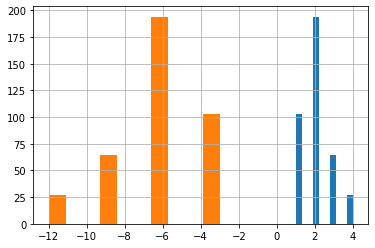

In [217]:
display(df.studytime.hist())
display(df['studytime, granular'].hist())
# Мы видим что значения 'studytime' и 'studytime, granular' можно получить по формуле:
# df['studytime, granular'] = df['studytime'] * (-3)

Таким образом мы можем избавиться от одной из этих колонок

In [218]:
df.drop(['studytime, granular'], inplace=True, axis=1)

### Проверяем ошибки в данных
При обследовании данных можно увидеть что в некоторых солонках наблюдаются ошибке:
Errors in DataSet: Fedu: 40.0, famrel: -1

In [219]:
display(df.Fedu.value_counts())
display(df.famrel.value_counts())

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [220]:
# Убираем данные значения, что бы не портили наши ряды
df = df.drop(df[df.Fedu > 4].index)
df = df.drop(df[df.famrel < 1].index)

display(df.Fedu.value_counts())
display(df.famrel.value_counts())

2.0    105
3.0     96
4.0     88
1.0     78
0.0      2
Name: Fedu, dtype: int64

4.0    182
5.0     98
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64

In [221]:
# Копируем исходный набор данных в переменную с которой будем дальше работать с корреляциями
correlation = df.copy()

### Приводим значение в object колонках в более удобную форму
В некоторых колонках хранится значение yes/no или F/M и.т.п. По своей сути это бинарные значения и могут быть заменеты на 1/0 или True /False. Мы будем для простоты работать с 1/0

Колонки с yes/no значениями - ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
В колонках 'school', 'sex', 'Pstatus', 'address', 'famsize', 'guardian', 'Mjob', 'Fjob' также заменяем текст на цифровое значение, чтобы упростить корреляцию (все колонки в одном формате - трудно с расшифровкой, но проще с анализом).

In [281]:
columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for column in columns:
    correlation[column] = correlation[column].replace('yes', 1)
    correlation[column] = correlation[column].replace('no', 0)

# Converting school column - we have only 2 values there GP and MS
correlation.school = correlation.school.replace('GP', 1)
correlation.school = correlation.school.replace('MS', 0)

# Converting sex column - we have only 2 values there F and M
correlation.sex = correlation.sex.replace('M', 1)
correlation.sex = correlation.sex.replace('F', 0)

# Converting Pstatus column - we have only 2 values there T and A
correlation.Pstatus = correlation.Pstatus.replace('T', 1)
correlation.Pstatus = correlation.Pstatus.replace('A', 0)

# Converting address column - we have only 2 values there U and R
correlation.address = correlation.address.replace('U', 1)
correlation.address = correlation.address.replace('R', 0)

# Converting famsize column - we have only 2 values there LE3 and GT3
correlation.famsize = correlation.famsize.replace('GT3', 1)
correlation.famsize = correlation.famsize.replace('LE3', 0)

# Converting guardian column - we have 3 values there mother(0), father(1) and other(2)
correlation.guardian = correlation.guardian.replace('mother', 0)
correlation.guardian = correlation.guardian.replace('father', 1)
correlation.guardian = correlation.guardian.replace('other', 2)

# Converting reason column - we have 3 values there home(0), reputation(1), course(2) and other(3)
correlation.reason = correlation.reason.replace('home', 0)
correlation.reason = correlation.reason.replace('reputation', 1)
correlation.reason = correlation.reason.replace('course', 2)
correlation.reason = correlation.reason.replace('other', 3)

# Converting Mjob and Fjob column
for column in ['Mjob', 'Fjob']:
    optimizing_job_column(df=correlation, column=column)

display(correlation.corr())

school       sex       age   address   famsize   Pstatus  \
school      1.000000  0.014074 -0.376995  0.286984  0.057936 -0.071655   
sex         0.014074  1.000000 -0.033299  0.003757 -0.096418  0.039071   
age        -0.376995 -0.033299  1.000000 -0.145778 -0.019462  0.015458   
address     0.286984  0.003757 -0.145778  1.000000 -0.060128 -0.064629   
famsize     0.057936 -0.096418 -0.019462 -0.060128  1.000000  0.078822   
Pstatus    -0.071655  0.039071  0.015458 -0.064629  0.078822  1.000000   
Medu        0.135195  0.077329 -0.165627  0.155416  0.058429 -0.131697   
Fedu        0.089652  0.031990 -0.160373  0.084419  0.086193 -0.111747   
Mjob       -0.066622 -0.117469  0.100458 -0.097093  0.106772 -0.008334   
Fjob        0.036588 -0.014771  0.047776 -0.026571 -0.041524  0.041729   
reason     -0.128128 -0.007124  0.004933 -0.127955  0.011278  0.063636   
guardian   -0.031632 -0.014176  0.259146  0.091795  0.069146  0.022706   
traveltime -0.257650  0.053791  0.089718 -0.290681 -0.045490  0.081029   
studytime   0.093161 -0.309646 -0.013463 -0.045258  0.086731  0.007697   
failures   -0.062265  0.045175  0.232135 -0.105466 -0.005690  0.011092   
schoolsup   0.140783 -0.140952 -0.259076  0.037468  0.035105 -0.035225   
famsup      0.184293 -0.158484 -0.155883  0.023405  0.120060 -0.027150   
paid        0.030725 -0.107803 -0.032216  0.052713  0.083259  0.040650   
activities  0.114787  0.109695 -0.108888 -0.052187  0.026052  0.104314   
nursery     0.110518  0.000452 -0.108305  0.054769 -0.101917 -0.065641   
higher      0.030913 -0.152600 -0.207278  0.052140  0.026371 -0.029150   
internet    0.101487  0.062336 -0.107099  0.208686  0.003026  0.059023   
romantic   -0.058847 -0.138724  0.141234 -0.008674 -0.013849 -0.049715   
famrel      0.036784  0.042612  0.068105 -0.011578  0.026237  0.016626   
freetime   -0.032799  0.228163  0.023114  0.059601 -0.021892  0.057306   
goout       0.008175  0.081414  0.130988  0.066311 -0.025287  0.038323   
health      0.036047  0.141617 -0.063539 -0.052173  0.045598  0.005176   
absences   -0.013790 -0.037695  0.093778  0.025492 -0.016448 -0.108210   
score       0.044747  0.099082 -0.155802  0.120485 -0.063047 -0.045985   

                Medu      Fedu      Mjob      Fjob    reason  guardian  \
school      0.135195  0.089652 -0.066622  0.036588 -0.128128 -0.031632   
sex         0.077329  0.031990 -0.117469 -0.014771 -0.007124 -0.014176   
age        -0.165627 -0.160373  0.100458  0.047776  0.004933  0.259146   
address     0.155416  0.084419 -0.097093 -0.026571 -0.127955  0.091795   
famsize     0.058429  0.086193  0.106772 -0.041524  0.011278  0.069146   
Pstatus    -0.131697 -0.111747 -0.008334  0.041729  0.063636  0.022706   
Medu        1.000000  0.629666 -0.532713 -0.214995 -0.028935 -0.144665   
Fedu        0.629666  1.000000 -0.343599 -0.359744 -0.037209 -0.006176   
Mjob       -0.532713 -0.343599  1.000000  0.278697 -0.089788  0.146642   
Fjob       -0.214995 -0.359744  0.278697  1.000000 -0.115803 -0.063412   
reason     -0.028935 -0.037209 -0.089788 -0.115803  1.000000 -0.131110   
guardian   -0.144665 -0.006176  0.146642 -0.063412 -0.131110  1.000000   
traveltime -0.171961 -0.156499  0.103108  0.070098  0.083698  0.086067   
studytime   0.078798  0.007017  0.011600 -0.006568 -0.076971  0.025167   
failures   -0.244267 -0.270989  0.108895 -0.005299  0.004421  0.223791   
schoolsup  -0.043843  0.051154  0.105197 -0.088917  0.005121 -0.019230   
famsup      0.211147  0.218208 -0.161028 -0.054193 -0.087420 -0.011385   
paid        0.179951  0.107279 -0.196623  0.029231 -0.109124 -0.083839   
activities  0.107204  0.109080 -0.121861 -0.045844 -0.019415 -0.021841   
nursery     0.187057  0.158867 -0.154397 -0.091815 -0.044040 -0.139536   
higher      0.177675  0.187321 -0.072354  0.034274 -0.141673 -0.018348   
internet    0.210749  0.133024 -0.161676 -0.028482 -0.056715 -0.003243   
romantic    0.021211  0.011943  0.076263 -0.058422  0.013084  0.080020   
famrel     -0.018

### score column
Наша основная задача это выяснить зависимость успеваемости ученика от других факторов. 
Для начала давайте посмотрим разброс значений в оценках

In [223]:
pd.DataFrame(correlation.score.value_counts())

score
50.0      54
55.0      46
0.0       37
75.0      33
65.0      31
40.0      30
60.0      30
70.0      27
45.0      27
80.0      16
30.0      15
90.0      12
35.0       9
25.0       7
85.0       6
95.0       5
100.0      1
20.0       1

Мы видим, что 37 записей со значением оценки = 0,0. Скорее всего, это означает отсутствие человека на экзаменах. Мы не знаем, почему это произошло. Этот человек мог получить любую оценку от самой низкой до самой высокой. Мы разделим эти записи в другой DataFrame. Таким образом у нас будет 2 DataFrames:
1. DataFrame только с данными об отсутствующих на экзамене
2. DataFrame без данных об отсутствующих на экзамене

Ещё мы видим две оценки явно претендующие на выбросы - одна оценка 100 и одна 20. Мы проверим эту теорию чуть ниже.


In [259]:
df_zero_score = correlation[correlation.score == 0]
df_nonzero_score = correlation[correlation.score > 0]

In [260]:
df_nonzero_score.corr()

school       sex       age   address   famsize   Pstatus  \
school      1.000000  0.016252 -0.387876  0.275767  0.075625 -0.070433   
sex         0.016252  1.000000 -0.030992  0.017280 -0.085966  0.031092   
age        -0.387876 -0.030992  1.000000 -0.153856 -0.032721 -0.002892   
address     0.275767  0.017280 -0.153856  1.000000 -0.057832 -0.054483   
famsize     0.075625 -0.085966 -0.032721 -0.057832  1.000000  0.087922   
Pstatus    -0.070433  0.031092 -0.002892 -0.054483  0.087922  1.000000   
Medu        0.109963  0.058392 -0.127411  0.160131  0.059119 -0.129829   
Fedu        0.063902  0.017491 -0.126262  0.094617  0.087653 -0.119391   
Mjob       -0.050602 -0.114003  0.073394 -0.090877  0.106292 -0.004004   
Fjob        0.034709  0.001437  0.031422 -0.047226 -0.033596  0.054311   
reason     -0.121457 -0.042829  0.038464 -0.098562  0.032155  0.060688   
guardian   -0.051076  0.005271  0.244608  0.055021  0.074427  0.052980   
traveltime -0.248234  0.053393  0.104695 -0.280162 -0.071913  0.074011   
studytime   0.095503 -0.297604 -0.009031 -0.049803  0.082153 -0.004332   
failures   -0.042570  0.035442  0.241688 -0.109674 -0.020990  0.012779   
schoolsup   0.145451 -0.155670 -0.261423  0.023953  0.033830 -0.038496   
famsup      0.171285 -0.157297 -0.126761  0.008054  0.081025 -0.009491   
paid        0.030315 -0.091922 -0.031055  0.041610  0.095587  0.041094   
activities  0.114255  0.166115 -0.133550 -0.090765  0.048530  0.108929   
nursery     0.122398 -0.019195 -0.115495  0.088022 -0.122663 -0.083609   
higher      0.073551 -0.120676 -0.208440  0.043633  0.020178 -0.016400   
internet    0.107293  0.072906 -0.114234  0.192057 -0.000947  0.080103   
romantic   -0.096606 -0.118506  0.180963 -0.008987  0.005230 -0.034765   
famrel      0.047240  0.050411  0.074120  0.015858  0.020995  0.011198   
freetime   -0.054390  0.207229 -0.001622  0.055733 -0.022582  0.062541   
goout      -0.042671  0.065984  0.119106  0.059352 -0.030360  0.006144   
health      0.038087  0.148517 -0.053539 -0.028105  0.044504  0.013820   
absences   -0.013133 -0.046623  0.112659  0.022879 -0.008233 -0.106919   
score       0.079432  0.100243 -0.133221  0.140059 -0.023570 -0.017252   

                Medu      Fedu      Mjob      Fjob    reason  guardian  \
school      0.109963  0.063902 -0.050602  0.034709 -0.121457 -0.051076   
sex         0.058392  0.017491 -0.114003  0.001437 -0.042829  0.005271   
age        -0.127411 -0.126262  0.073394  0.031422  0.038464  0.244608   
address     0.160131  0.094617 -0.090877 -0.047226 -0.098562  0.055021   
famsize     0.059119  0.087653  0.106292 -0.033596  0.032155  0.074427   
Pstatus    -0.129829 -0.119391 -0.004004  0.054311  0.060688  0.052980   
Medu        1.000000  0.610995 -0.510618 -0.218434 -0.041571 -0.165055   
Fedu        0.610995  1.000000 -0.315697 -0.359529 -0.056418 -0.021639   
Mjob       -0.510618 -0.315697  1.000000  0.274973 -0.093596  0.151519   
Fjob       -0.218434 -0.359529  0.274973  1.000000 -0.126077 -0.053526   
reason     -0.041571 -0.056418 -0.093596 -0.126077  1.000000 -0.106925   
guardian   -0.165055 -0.021639  0.151519 -0.053526 -0.106925  1.000000   
traveltime -0.163279 -0.157956  0.084982  0.067283  0.056007  0.087209   
studytime   0.070684 -0.017564  0.040055  0.010286 -0.089248  0.006385   
failures   -0.203566 -0.266833  0.072488  0.015004  0.063462  0.183860   
schoolsup  -0.062380  0.048999  0.125548 -0.104213  0.012275 -0.002544   
famsup      0.187466  0.221666 -0.158979 -0.055728 -0.073280 -0.006141   
paid        0.161158  0.102559 -0.199739  0.035668 -0.116719 -0.093447   
activities  0.126913  0.102385 -0.121793 -0.090911 -0.018413 -0.030201   
nursery     0.182302  0.181375 -0.154429 -0.075149 -0.048693 -0.082588   
higher      0.209555  0.185807 -0.075501  0.022402 -0.169353 -0.070895   
internet    0.208730  0.159850 -0.161854 -0.036948 -0.034698 -0.029066   
romantic    0.058224  0.037043  0.068769 -0.037988  0.022651  0.085252   
famrel     -0.011

In [261]:
df_zero_score.corr()

school       sex       age   address   famsize   Pstatus  \
school      1.000000  0.110201 -0.321935  0.372750 -0.158397 -0.094333   
sex         0.110201  1.000000 -0.034510 -0.104828 -0.165186  0.204782   
age        -0.321935 -0.034510  1.000000 -0.103439 -0.097454  0.101172   
address     0.372750 -0.104828 -0.103439  1.000000 -0.120553 -0.174078   
famsize    -0.158397 -0.165186 -0.097454 -0.120553  1.000000 -0.133631   
Pstatus    -0.094333  0.204782  0.101172 -0.174078 -0.133631  1.000000   
Medu        0.372801  0.240329 -0.277001  0.147631  0.289636 -0.033331   
Fedu        0.266034  0.164919 -0.308023  0.019181  0.240466  0.063383   
Mjob       -0.231460 -0.098089  0.138067 -0.226632 -0.042402 -0.180362   
Fjob       -0.008720 -0.077174  0.289786  0.130569 -0.152106 -0.115796   
reason     -0.316397  0.285192 -0.164234 -0.411304 -0.129866  0.237965   
guardian    0.237828 -0.202721  0.051155  0.343693 -0.160357 -0.429276   
traveltime -0.227429  0.044992 -0.173553 -0.400463  0.190997  0.141220   
studytime   0.075899 -0.440298 -0.043985 -0.037813  0.146526  0.137874   
failures   -0.050398  0.165926 -0.062840 -0.011143 -0.095038 -0.147181   
schoolsup   0.058026  0.201843 -0.264694  0.104828  0.088636  0.044901   
famsup      0.233314 -0.066667 -0.349795  0.138215  0.563323 -0.223178   
paid       -0.039841 -0.376051  0.141861  0.112263  0.069293  0.147442   
activities  0.051848 -0.290185  0.122217  0.310759 -0.262265  0.042919   
nursery     0.048391  0.197708  0.076472 -0.187639  0.164488  0.168505   
higher     -0.158114 -0.407718 -0.200821  0.047946  0.139771 -0.097590   
internet    0.120173 -0.091698 -0.178410  0.360599  0.082158 -0.133631   
romantic    0.211172 -0.244181 -0.179145  0.076472 -0.290801 -0.258199   
famrel      0.026485 -0.042143 -0.013915 -0.259398  0.066536  0.067579   
freetime    0.246957  0.407872  0.189722  0.055762 -0.078085  0.000000   
goout       0.445435  0.276847  0.090751  0.103906 -0.075272  0.302653   
health     -0.095766  0.172329 -0.224359 -0.273830  0.008098 -0.151911   
absences         NaN       NaN       NaN       NaN       NaN       NaN   
score            NaN       NaN       NaN       NaN       NaN       NaN   

                Medu          Fedu      Mjob      Fjob    reason  guardian  \
school      0.372801  2.660340e-01 -0.231460 -0.008720 -0.316397  0.237828   
sex         0.240329  1.649192e-01 -0.098089 -0.077174  0.285192 -0.202721   
age        -0.277001 -3.080227e-01  0.138067  0.289786 -0.164234  0.051155   
address     0.147631  1.918054e-02 -0.226632  0.130569 -0.411304  0.343693   
famsize     0.289636  2.404664e-01 -0.042402 -0.152106 -0.129866 -0.160357   
Pstatus    -0.033331  6.338303e-02 -0.180362 -0.115796  0.237965 -0.429276   
Medu        1.000000  7.634200e-01 -0.703553 -0.216506 -0.048529  0.216699   
Fedu        0.763420  1.000000e+00 -0.547347 -0.402532  0.061904  0.335693   
Mjob       -0.703553 -5.473472e-01  1.000000  0.371156  0.054690 -0.120576   
Fjob       -0.216506 -4.025318e-01  0.371156  1.000000 -0.049037 -0.052505   
reason     -0.048529  6.190421e-02  0.054690 -0.049037  1.000000 -0.362388   
guardian    0.216699  3.356931e-01 -0.120576 -0.052505 -0.362388  1.000000   
traveltime -0.139369  1.334877e-02  0.236930  0.097020  0.483866 -0.030392   
studytime   0.138471  2.431538e-01 -0.272318 -0.180361 -0.017546  0.111757   
failures   -0.314499 -2.578080e-01  0.229190 -0.006076 -0.161806  0.149134   
schoolsup   0.274204  1.041791e-01 -0.348376 -0.132818       NaN  0.134837   
famsup      0.371843  1.606351e-01 -0.187993 -0.121573 -0.245702  0.031840   
paid        0.039075 -7.523548e-02 -0.059159 -0.013121 -0.168543 -0.030096   
activities -0.051928  1.189752e-01 -0.185526  0.337447  0.075710  0.206958   
nursery     0.117580 -1.364274e-01 -0.084747 -0.256055  0.122782 -0.332026   
higher     -0.033787  1.868675e-01 -0.076425  0.111933 -0.091395  0.183065   
internet    0.282086  7.732147e-17 -0.190808  0.102500 -0.278693  0.050252   

Интересная особенность просматривается во всех 37 записях учеников получивших оценку 0.
 - большое количество (больше чем в другом наборе данных где оценка больше 0) пропусков в данных - ни по одной колонне за исключением 'age', 'sex' и 'school' нет полных 37 заполненых клеток
 - у всех в колонке 'absence' стоит 0, то есть данные ученики стабтильно не пропустили ни одного дня, что само по себе странно, учитывая что это не что-то из ряда вон выходящее - в другом наборе данных только 74 из 350 учеников не имеют пропусков (21.14%). 

По другим колонкам в основном процентный разброс по значениям примерно равный в обоих наборах данных, аномалия присутствует только в колонке 'absense'.
Изходя из этого мы можем предположить что ученики имеющие оценку 0 могли просто не доучиться до конца учебного года по тем или иным причинам. Из-за этогу у них неполные учётные записи и не заполнены пропущеные занятия (такое может случиться если ученик подал документы и зарегестрировался в учебном заведении - отсюда полностью заполненые колонки "пол", "школа" и "возраст" - но либо не началали обучение, либо покинули учебное заведение вскоре после начала обучения.

Сложно другим образом объяснить, что такие "обязательные" ученики, не пропустившие ни одного занятия, все как один не пришли на экзамены.

Изходя из этих соображений в дальнейшем мы будем работать только с данными на учеников получивших оценку больше 0 - 'df_nonzero_score'

In [262]:
display(df_zero_score.absences.value_counts())
display(df_nonzero_score.absences.value_counts())

0.0    36
Name: absences, dtype: int64

0.0      74
2.0      60
4.0      51
6.0      30
8.0      20
10.0     17
12.0     12
14.0     11
3.0       7
16.0      7
7.0       6
18.0      5
5.0       5
20.0      4
22.0      3
9.0       3
1.0       3
15.0      2
13.0      2
11.0      2
25.0      1
54.0      1
385.0     1
26.0      1
56.0      1
24.0      1
212.0     1
21.0      1
75.0      1
30.0      1
19.0      1
38.0      1
40.0      1
23.0      1
17.0      1
28.0      1
Name: absences, dtype: int64

In [263]:
# Сравниваем все колонки двух наборов данных
for column in df_zero_score.columns:
    print('Value counts for column', column)
    display(df_zero_score[column].value_counts())
    display(df_nonzero_score[column].value_counts())
    print('-'*80)

Value counts for column school


1    33
0     4
Name: school, dtype: int64

1    309
0     41
Name: school, dtype: int64

--------------------------------------------------------------------------------
Value counts for column sex


0    22
1    15
Name: sex, dtype: int64

0    180
1    170
Name: sex, dtype: int64

--------------------------------------------------------------------------------
Value counts for column age


18    11
17     8
16     7
15     6
19     5
Name: age, dtype: int64

16    95
17    90
15    75
18    69
19    16
20     3
22     1
21     1
Name: age, dtype: int64

--------------------------------------------------------------------------------
Value counts for column address


1.0    26
0.0    10
Name: address, dtype: int64

1.0    263
0.0     73
Name: address, dtype: int64

--------------------------------------------------------------------------------
Value counts for column famsize


1.0    27
0.0     7
Name: famsize, dtype: int64

1.0    226
0.0    100
Name: famsize, dtype: int64

--------------------------------------------------------------------------------
Value counts for column Pstatus


1.0    31
0.0     2
Name: Pstatus, dtype: int64

1.0    277
0.0     34
Name: Pstatus, dtype: int64

--------------------------------------------------------------------------------
Value counts for column Medu


2.0    12
1.0     9
3.0     9
4.0     6
Name: Medu, dtype: int64

4.0    125
3.0     87
2.0     86
1.0     47
0.0      3
Name: Medu, dtype: int64

--------------------------------------------------------------------------------
Value counts for column Fedu


2.0    11
1.0    10
4.0     8
3.0     5
Name: Fedu, dtype: int64

2.0    93
3.0    89
4.0    80
1.0    65
0.0     2
Name: Fedu, dtype: int64

--------------------------------------------------------------------------------
Value counts for column Mjob


4.0    12
3.0     9
2.0     8
0.0     4
1.0     2
Name: Mjob, dtype: int64

4.0    115
2.0     88
0.0     51
3.0     49
1.0     30
Name: Mjob, dtype: int64

--------------------------------------------------------------------------------
Value counts for column Fjob


4.0    18
2.0    10
0.0     3
3.0     2
Name: Fjob, dtype: int64

4.0    175
2.0     88
0.0     26
1.0     15
3.0     14
Name: Fjob, dtype: int64

--------------------------------------------------------------------------------
Value counts for column reason


2.0    16
0.0    12
1.0     6
3.0     1
Name: reason, dtype: int64

2.0    119
1.0     95
0.0     88
3.0     33
Name: reason, dtype: int64

--------------------------------------------------------------------------------
Value counts for column guardian


0.0    23
1.0     8
2.0     4
Name: guardian, dtype: int64

0.0    224
1.0     77
2.0     20
Name: guardian, dtype: int64

--------------------------------------------------------------------------------
Value counts for column traveltime


1.0    20
2.0     8
3.0     4
Name: traveltime, dtype: int64

1.0    218
2.0     86
3.0     16
4.0      7
Name: traveltime, dtype: int64

--------------------------------------------------------------------------------
Value counts for column studytime


2.0    16
1.0    13
3.0     5
4.0     3
Name: studytime, dtype: int64

2.0    173
1.0     89
3.0     57
4.0     24
Name: studytime, dtype: int64

--------------------------------------------------------------------------------
Value counts for column failures


0.0    17
1.0    10
3.0     4
2.0     4
Name: failures, dtype: int64

0.0    272
1.0     38
2.0     10
3.0     10
Name: failures, dtype: int64

--------------------------------------------------------------------------------
Value counts for column schoolsup


0.0    36
1.0     1
Name: schoolsup, dtype: int64

0.0    293
1.0     48
Name: schoolsup, dtype: int64

--------------------------------------------------------------------------------
Value counts for column famsup


1.0    20
0.0    15
Name: famsup, dtype: int64

1.0    194
0.0    120
Name: famsup, dtype: int64

--------------------------------------------------------------------------------
Value counts for column paid


0.0    27
1.0     7
Name: paid, dtype: int64

0.0    169
1.0    145
Name: paid, dtype: int64

--------------------------------------------------------------------------------
Value counts for column activities


1.0    20
0.0    15
Name: activities, dtype: int64

1.0    171
0.0    167
Name: activities, dtype: int64

--------------------------------------------------------------------------------
Value counts for column nursery


1.0    25
0.0     9
Name: nursery, dtype: int64

1.0    271
0.0     67
Name: nursery, dtype: int64

--------------------------------------------------------------------------------
Value counts for column higher


1.0    30
0.0     6
Name: higher, dtype: int64

1.0    318
0.0     13
Name: higher, dtype: int64

--------------------------------------------------------------------------------
Value counts for column internet


1.0    26
0.0     6
Name: internet, dtype: int64

1.0    272
0.0     49
Name: internet, dtype: int64

--------------------------------------------------------------------------------
Value counts for column romantic


1.0    19
0.0    16
Name: romantic, dtype: int64

0.0    217
1.0    104
Name: romantic, dtype: int64

--------------------------------------------------------------------------------
Value counts for column famrel


4.0    15
5.0     9
3.0     6
2.0     3
1.0     1
Name: famrel, dtype: int64

4.0    163
5.0     87
3.0     56
2.0     14
1.0      6
Name: famrel, dtype: int64

--------------------------------------------------------------------------------
Value counts for column freetime


3.0    20
4.0     8
2.0     4
1.0     2
5.0     2
Name: freetime, dtype: int64

3.0    132
4.0    102
2.0     57
5.0     35
1.0     16
Name: freetime, dtype: int64

--------------------------------------------------------------------------------
Value counts for column goout


2.0    9
5.0    8
3.0    8
4.0    7
1.0    4
Name: goout, dtype: int64

3.0    118
2.0     90
4.0     74
5.0     43
1.0     19
Name: goout, dtype: int64

--------------------------------------------------------------------------------
Value counts for column health


5.0    13
3.0     7
4.0     7
2.0     6
1.0     2
Name: health, dtype: int64

5.0    123
3.0     81
4.0     52
1.0     45
2.0     36
Name: health, dtype: int64

--------------------------------------------------------------------------------
Value counts for column absences


0.0    36
Name: absences, dtype: int64

0.0      74
2.0      60
4.0      51
6.0      30
8.0      20
10.0     17
12.0     12
14.0     11
3.0       7
16.0      7
7.0       6
18.0      5
5.0       5
20.0      4
22.0      3
9.0       3
1.0       3
15.0      2
13.0      2
11.0      2
25.0      1
54.0      1
385.0     1
26.0      1
56.0      1
24.0      1
212.0     1
21.0      1
75.0      1
30.0      1
19.0      1
38.0      1
40.0      1
23.0      1
17.0      1
28.0      1
Name: absences, dtype: int64

--------------------------------------------------------------------------------
Value counts for column score


0.0    37
Name: score, dtype: int64

50.0     54
55.0     46
75.0     33
65.0     31
40.0     30
60.0     30
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

--------------------------------------------------------------------------------


== До того как почистили выбросы ==


count    305.000000
mean      57.688525
std       16.196309
min       20.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

== После того как почистили выбросы ==


count    305.000000
mean      57.688525
std       16.196309
min       20.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

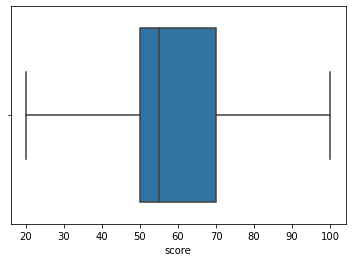

In [309]:
# Оставляем все значения больше нуля в колонке 'score' и строим boxplot чтобы проверить выбросы
# Нет выбросов согласно данному графику
display(sns.boxplot(df_nonzero_score.score))
# get_boxplot(df=df_nonzero_score, column='score', y=None, hue=None)
df_nonzero_score = removing_outliers(df=df_nonzero_score, column='score')

## age column
Давайте проверим колонку 'age', какой там разброс значений
Присутствуют ученики школы в возрасте 20, 21 и 22 года.
Это какие-то неправилные пчёлы.

Ещё можно представить учеников школы в возрасте 19 лет (хотя и это надо постараться), но в 20 и после это явная ошибка.

In [288]:
display(df_nonzero_score.age.describe())
display(df_nonzero_score.age.value_counts())

count    350.000000
mean      16.640000
std        1.256091
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

16    95
17    90
15    75
18    69
19    16
20     3
22     1
21     1
Name: age, dtype: int64

In [324]:
df_nonzero_score = df_nonzero_score.drop(df_nonzero_score[df_nonzero_score.age > 19].index)
display(df_nonzero_score.age.describe())
display(df_nonzero_score.age.value_counts())

count    301.00000
mean      16.58804
std        1.16750
min       15.00000
25%       16.00000
50%       17.00000
75%       17.00000
max       19.00000
Name: age, dtype: float64

16    85
17    78
15    64
18    59
19    15
Name: age, dtype: int64

## famrel column
Проверим колонку 'famrel' на выбросы

In [325]:
display(df_nonzero_score.famrel.describe())
display(df_nonzero_score.famrel.value_counts())
df_nonzero_score = removing_outliers(df=df_nonzero_score, column='famrel')

count    301.000000
mean       4.086379
std        0.672691
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

4.0    163
5.0     82
3.0     56
Name: famrel, dtype: int64

== До того как почистили выбросы ==


count    301.000000
mean       4.086379
std        0.672691
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

== После того как почистили выбросы ==


count    301.000000
mean       4.086379
std        0.672691
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

In [326]:
display(df_nonzero_score.famrel.value_counts())

4.0    163
5.0     82
3.0     56
Name: famrel, dtype: int64

## Boxplots
Построим boxplots и постараемся проанализировать визуальную информацию

Plotting  Medu


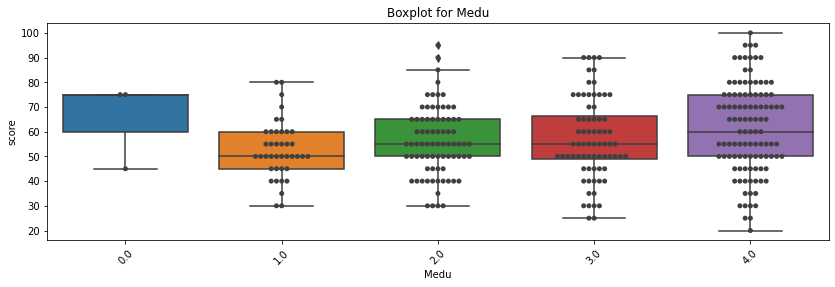

Plotting  Fedu


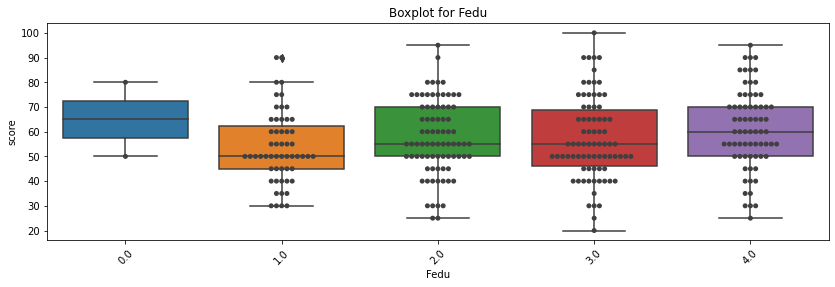

Plotting  Mjob


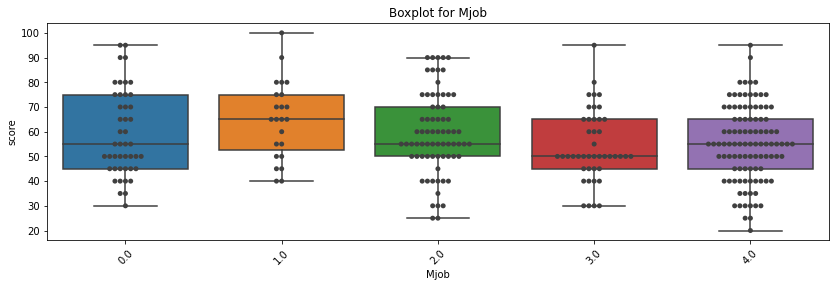

Plotting  Fjob


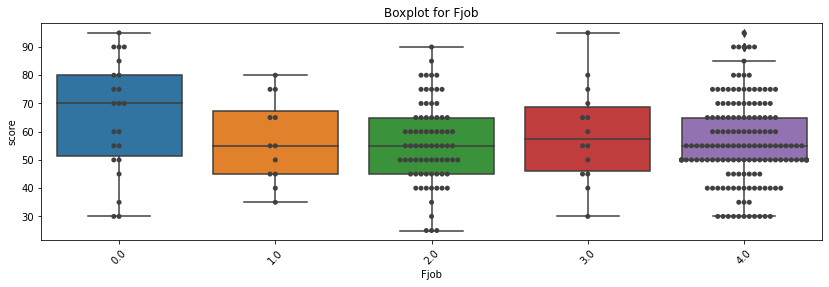

In [336]:
for column in ['Medu', 'Fedu', 'Mjob', 'Fjob']:
    if column == 'score':
        continue
    get_boxplot(df=df_nonzero_score, column=column, y='score', hue=None)

### Колонки 'Medu', 'Fedu', 'Mjob' и 'Fjob'
Несмотря на их относительно высокую корреляцию (соответственно 0.185018, 0.133649, -0.162727, -0.108363) относительно оценок (по сравнению с другими корреляциями) при анализе графиков мы видим, что в основном данные в этих колонках слабо влияют на оценки. Разброс среднего балла не больше 5-7 баллов. Небольшое исключение (позитивное влияние) составляет работа отца учителем (Fjob 0) но таких учеников не много.

Также можно видеть что для 'Medu' и 'Fedu' отсутствие образования у отца или матери (0) это позитивный фактор, но по факту мы видим что это больше влияние малой выборки: в 'Medu' только у троих учеников у матери нет образования, в 'Fedu' только у двоих учеников у отца нет образования.

Считаю что данные колонки можно будет исключить из дальнейшего анализа.

In [337]:
df_nonzero_score.drop(['Medu', 'Fedu', 'Mjob', 'Fjob'], inplace=True, axis=1)

Plotting  sex


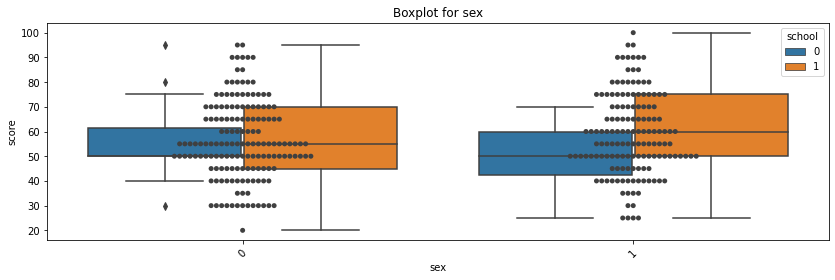

Plotting  age


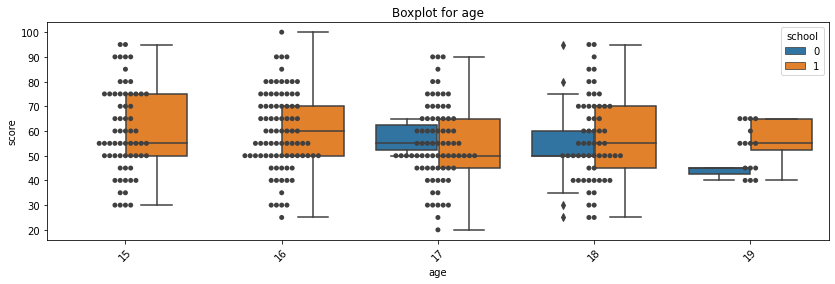

Plotting  address


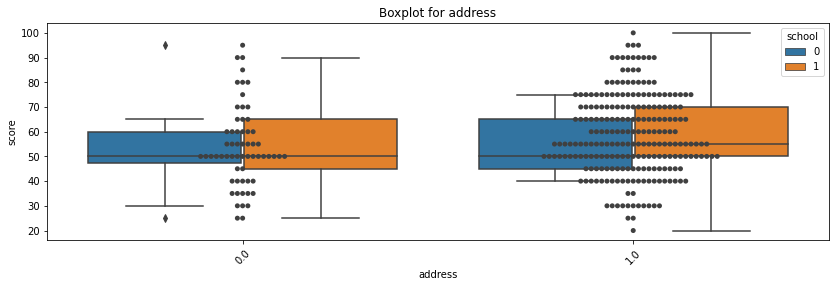

Plotting  famsize


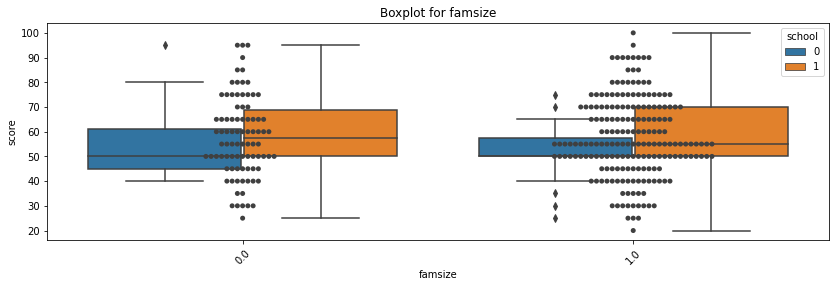

Plotting  Pstatus


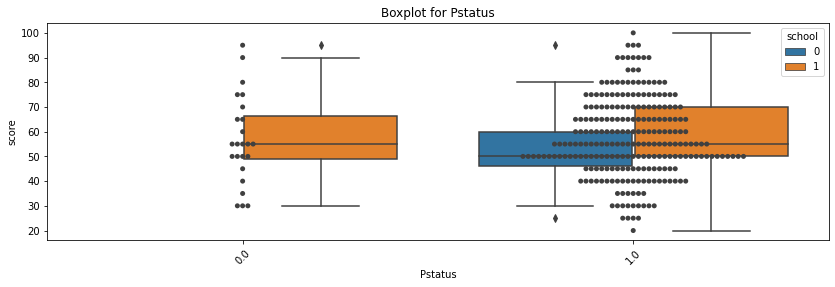

Plotting  reason


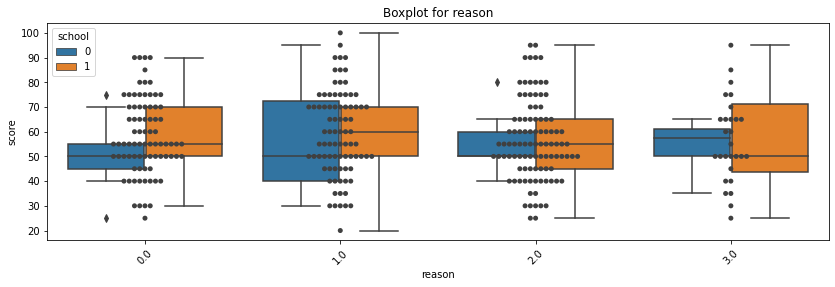

Plotting  guardian


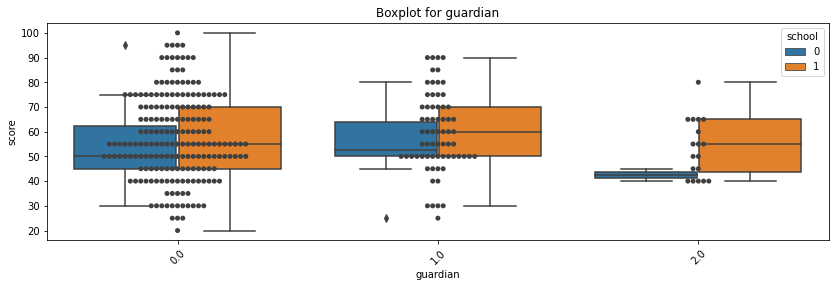

Plotting  traveltime


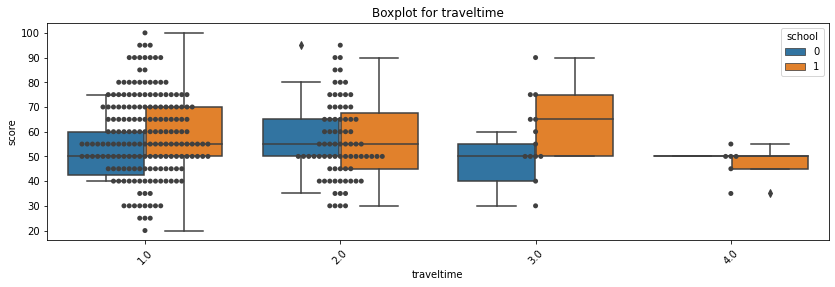

Plotting  studytime


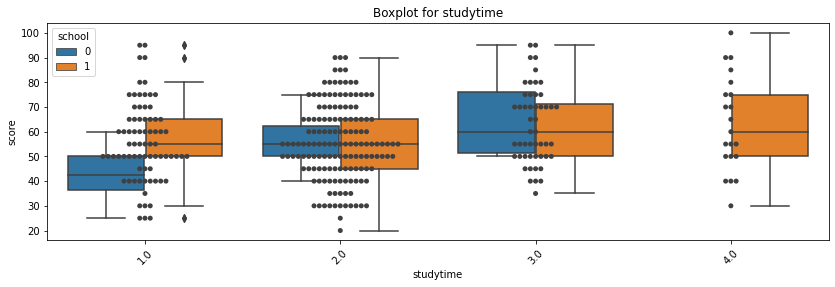

Plotting  failures


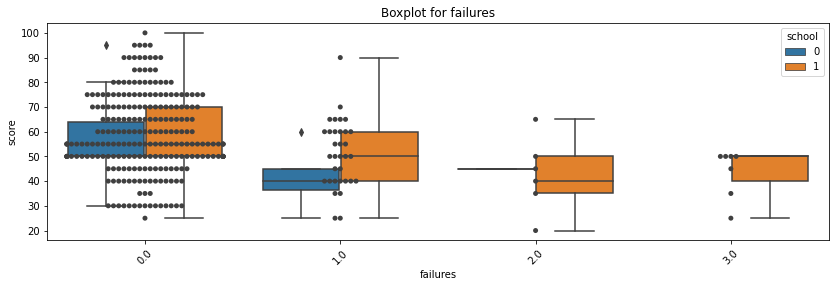

Plotting  schoolsup


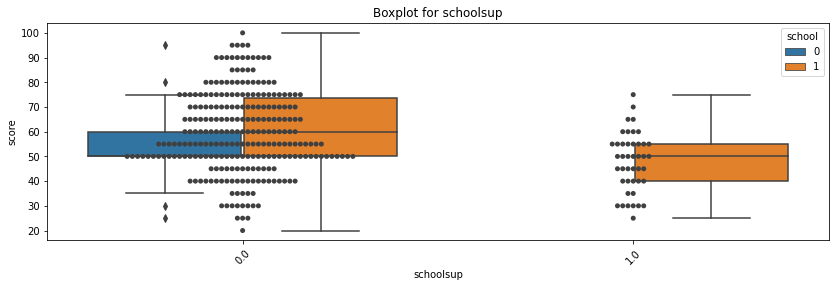

Plotting  famsup


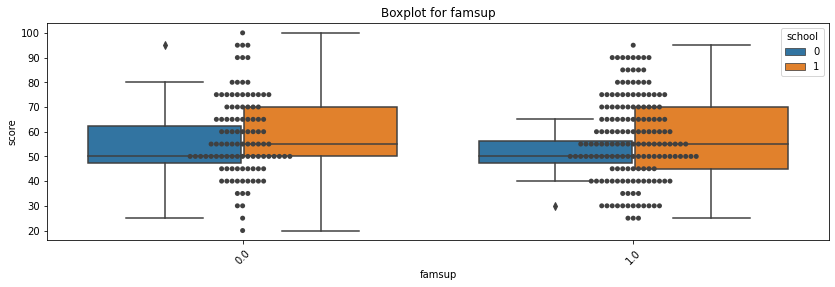

Plotting  paid


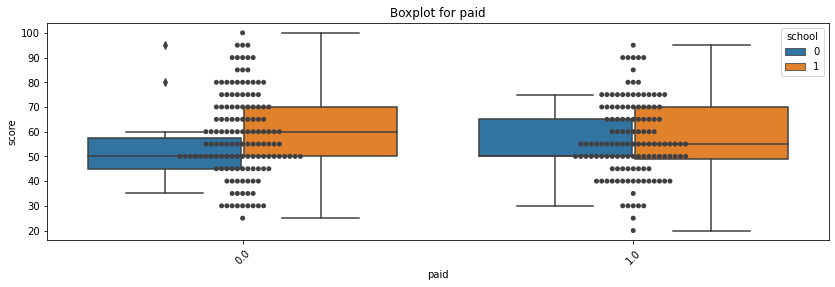

Plotting  activities


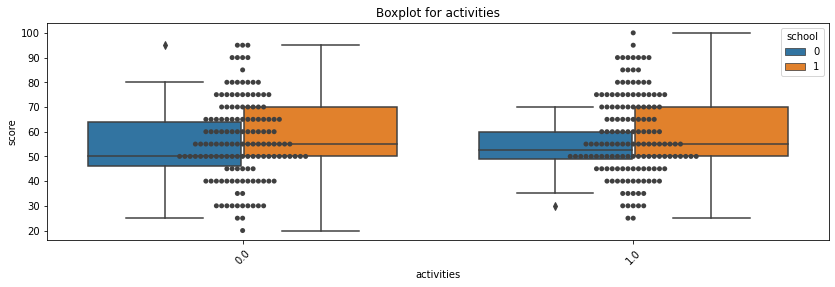

Plotting  nursery


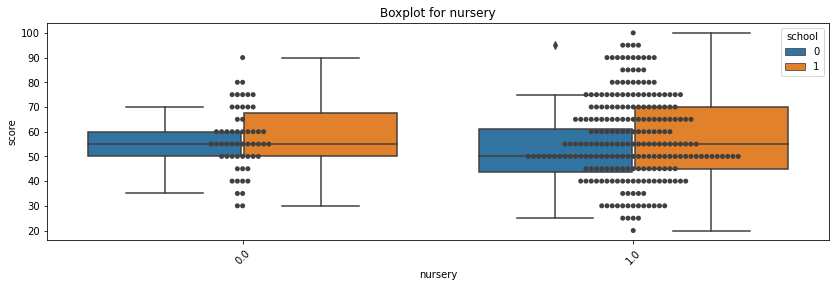

Plotting  higher


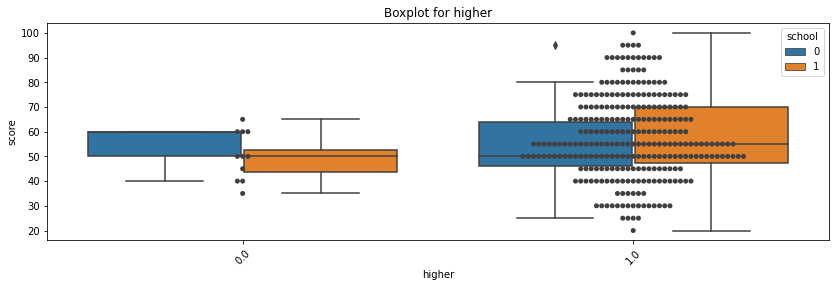

Plotting  internet


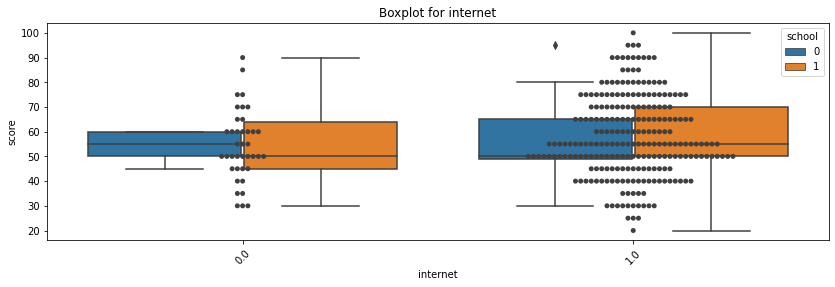

Plotting  romantic


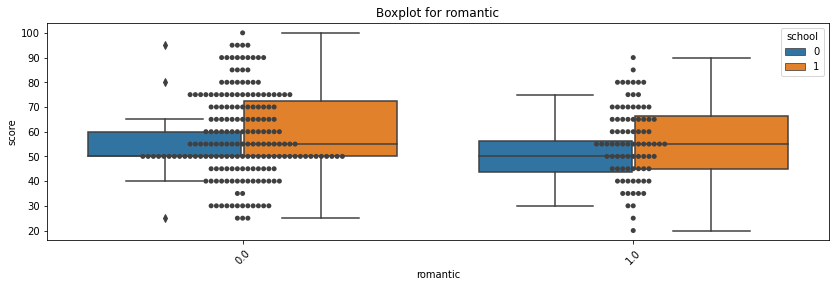

Plotting  famrel


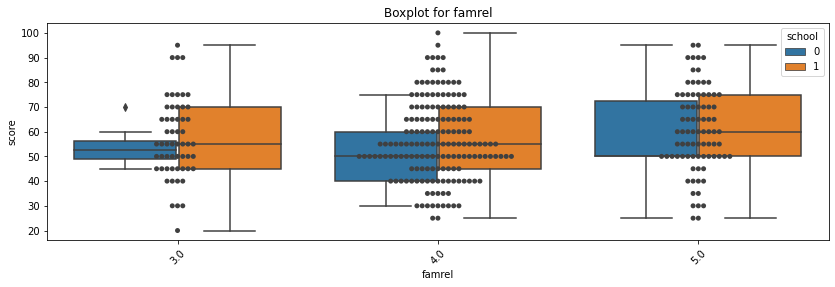

Plotting  freetime


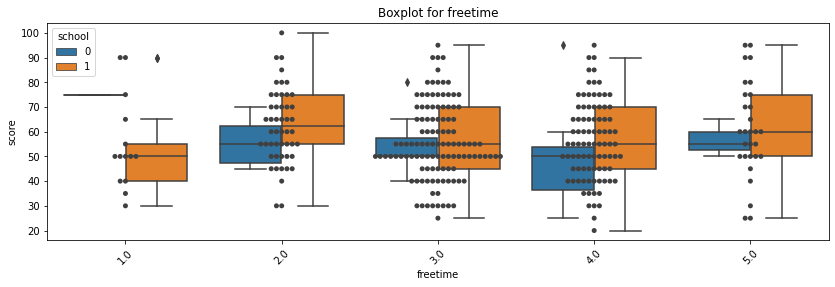

Plotting  goout


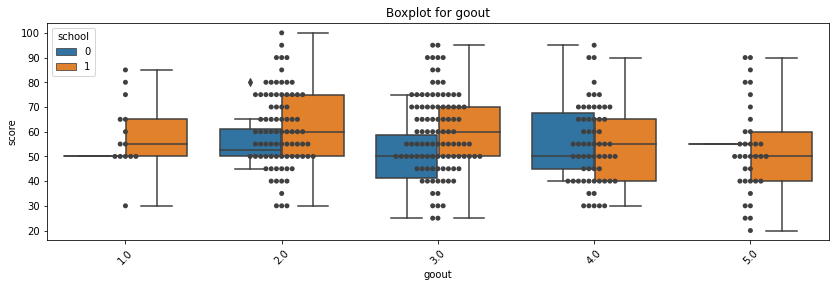

Plotting  health


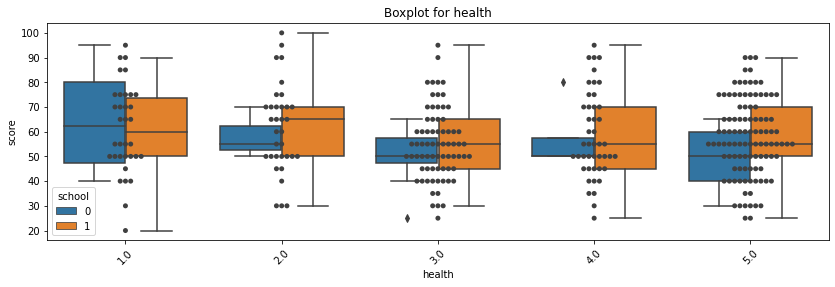

Plotting  absences


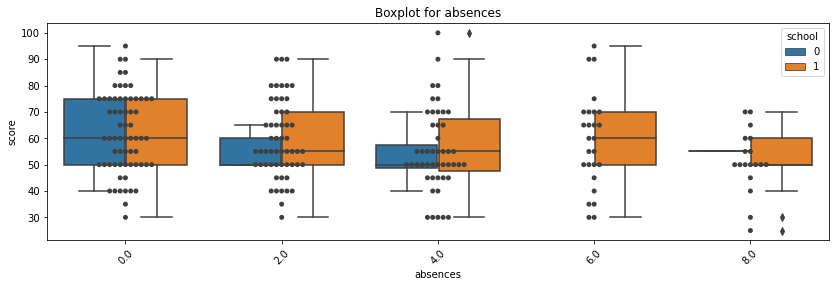

In [338]:
# Смотрим как влияет тип школы на оценку - GP (1) имеет явно лучшие показатели.
# То есть ученик в школе типа GP в среднем получает на 8-10 баллов выше оценку чем в школе типа MS
for column in df_nonzero_score.columns:
    if column == 'score' or column=='school':
        continue
    get_boxplot(df=df_nonzero_score, column=column, y='score', hue='school')

======================================== nursery ========================================
Plotting  school


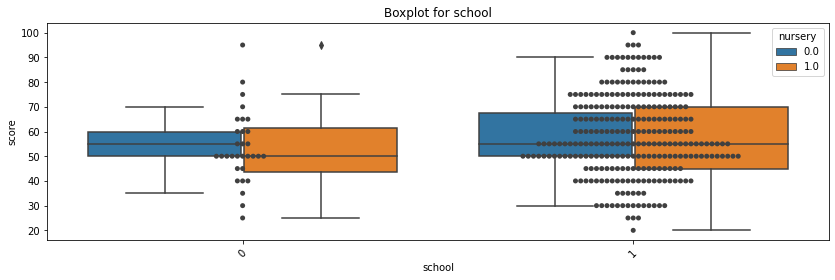

Plotting  sex


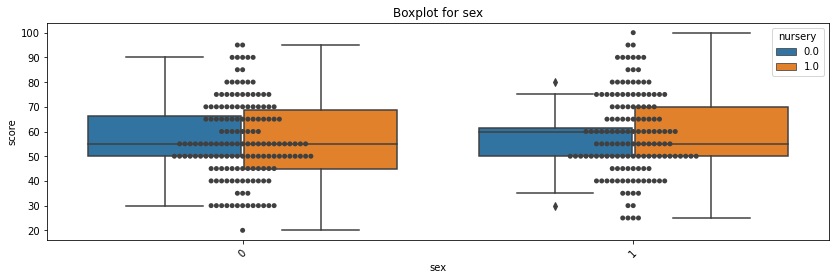

Plotting  age


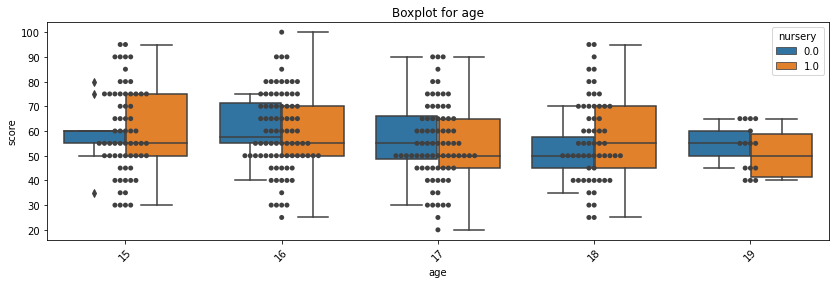

Plotting  address


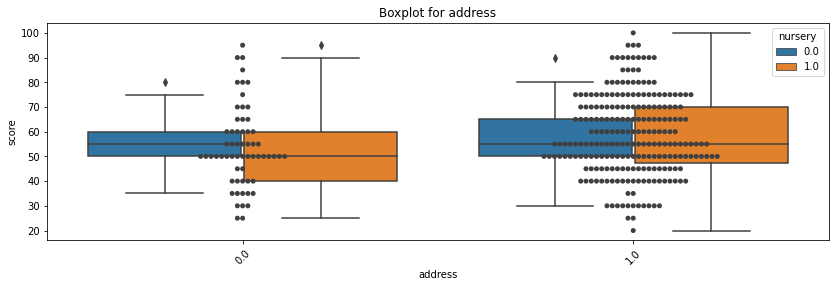

Plotting  famsize


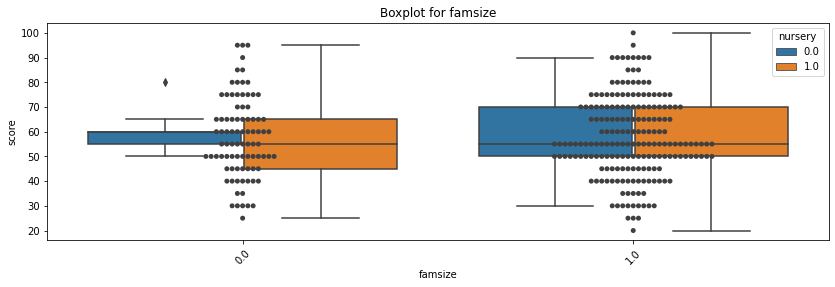

Plotting  Pstatus


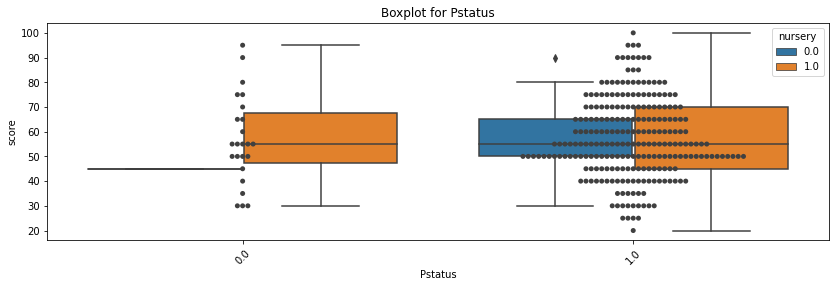

Plotting  reason


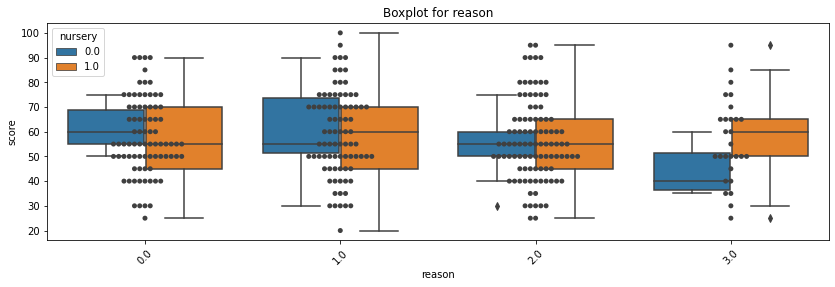

Plotting  guardian


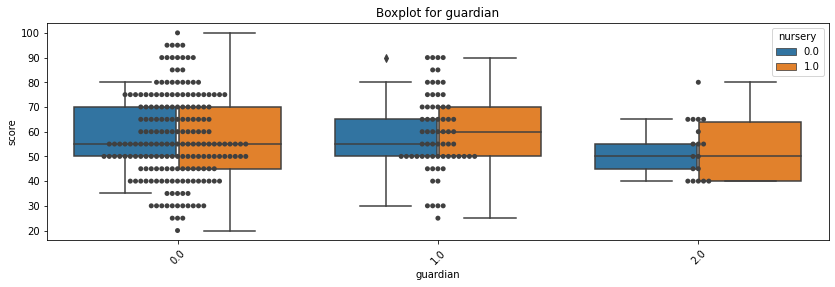

Plotting  traveltime


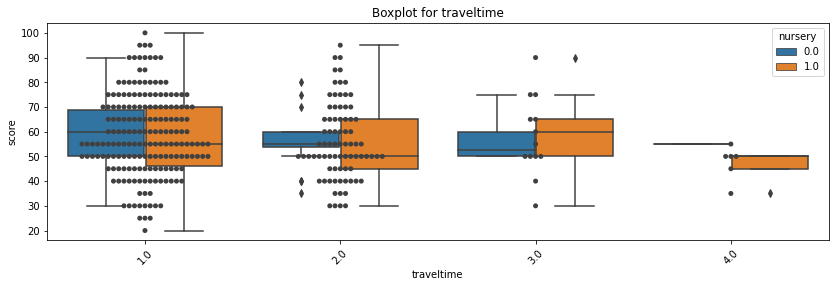

Plotting  studytime


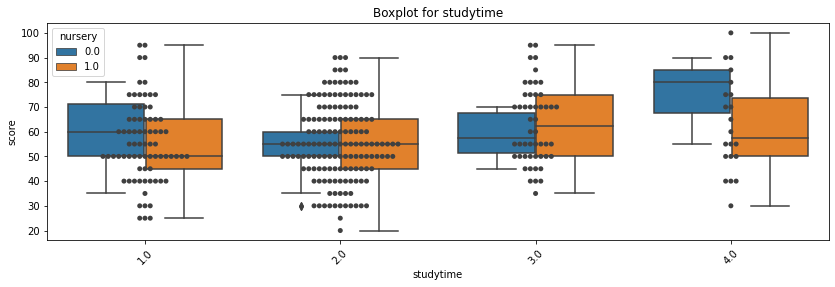

Plotting  failures


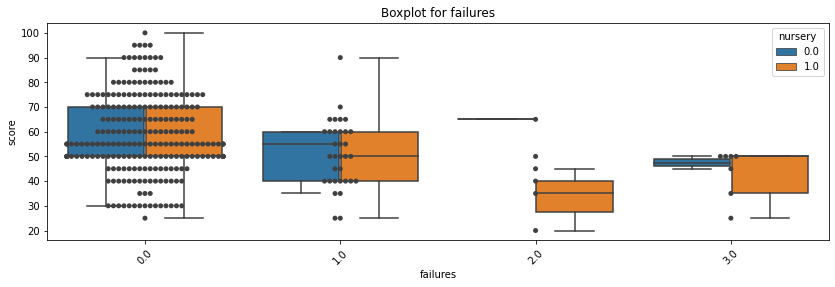

Plotting  schoolsup


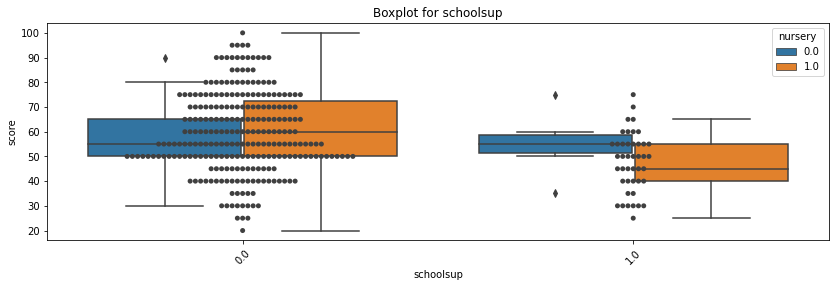

Plotting  famsup


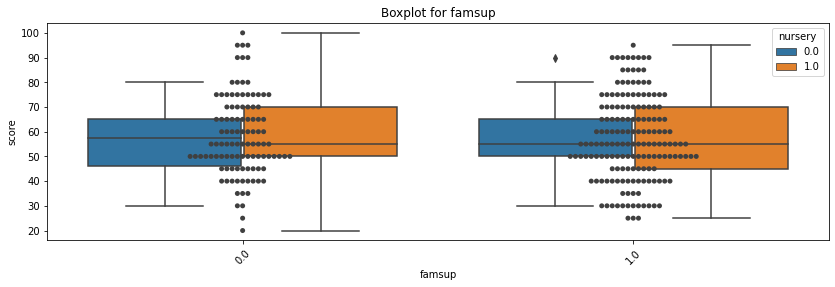

Plotting  paid


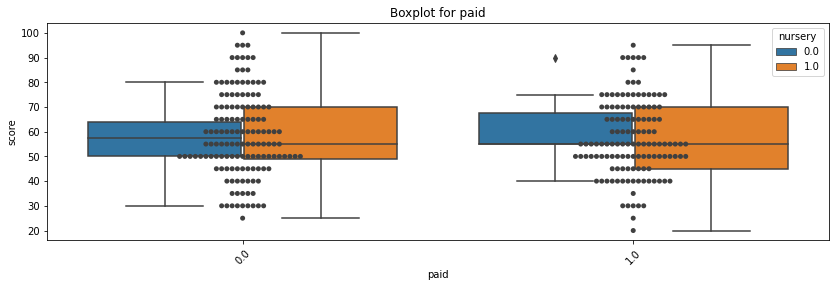

Plotting  activities


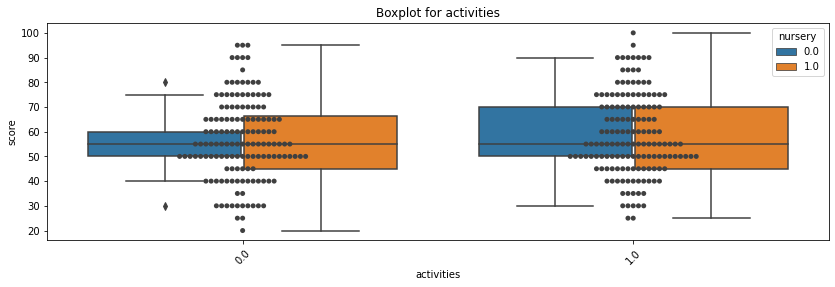

Plotting  higher


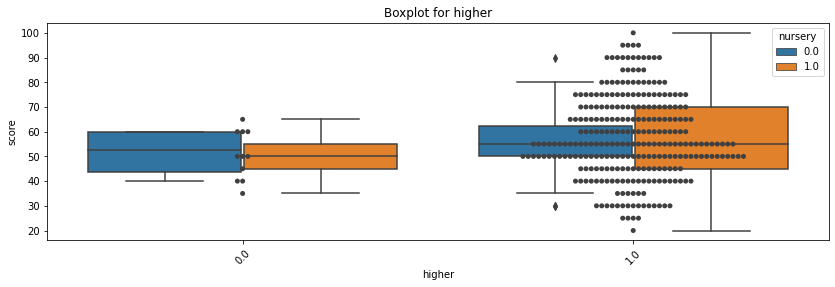

Plotting  internet


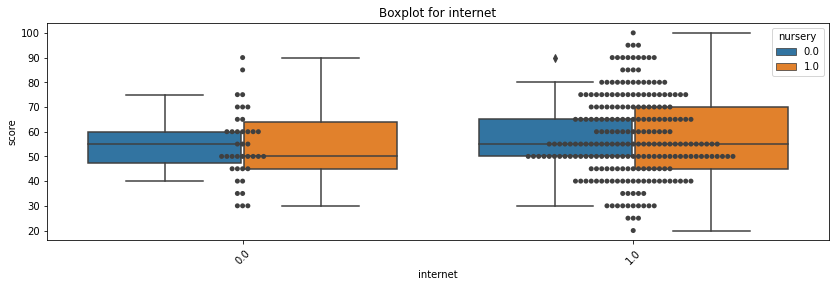

Plotting  romantic


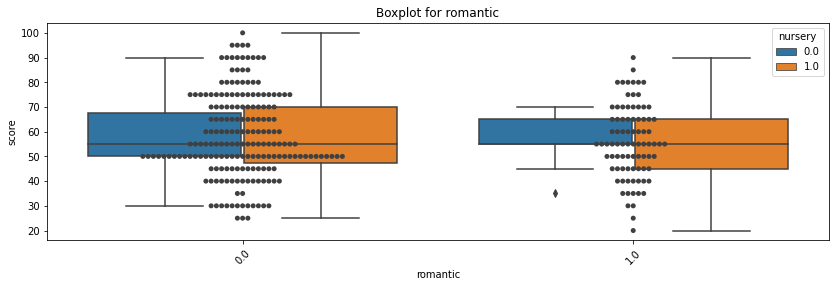

Plotting  famrel


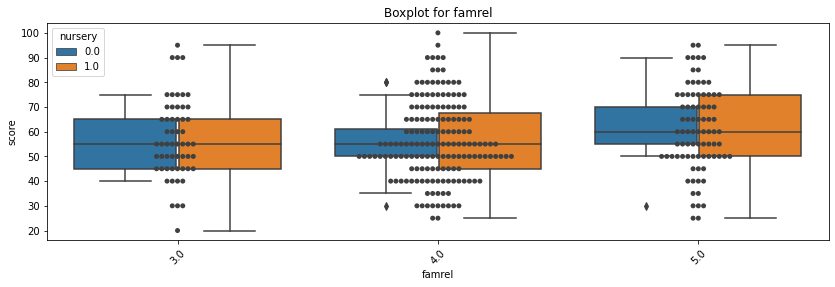

Plotting  freetime


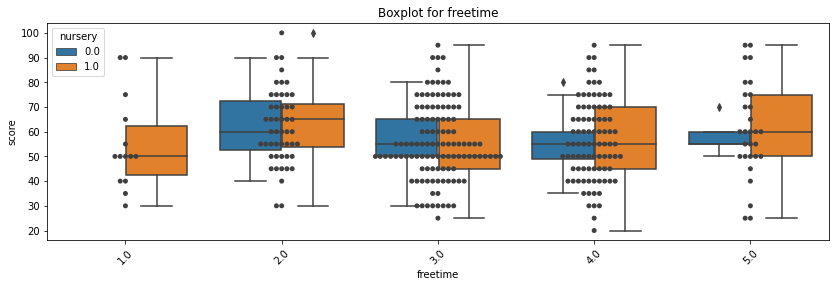

Plotting  goout


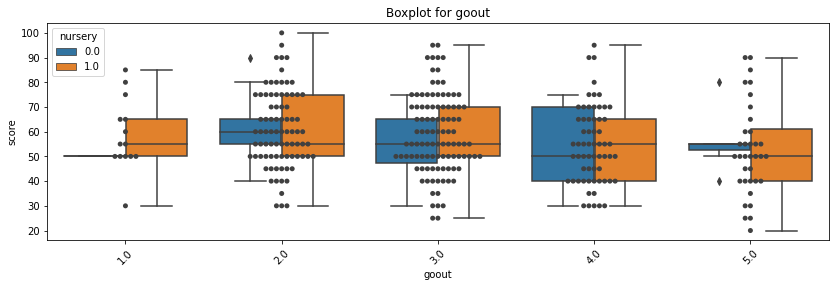

Plotting  health


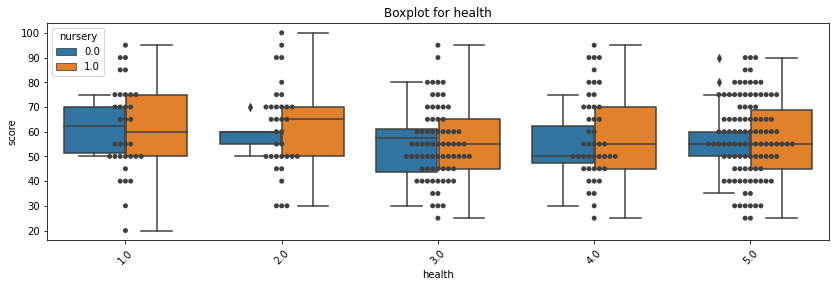

Plotting  absences


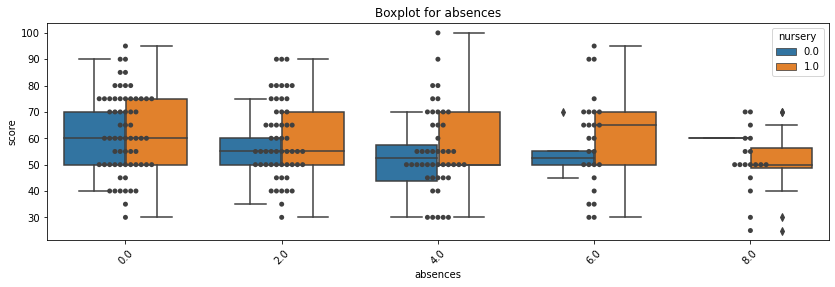

======================================== internet ========================================
Plotting  school


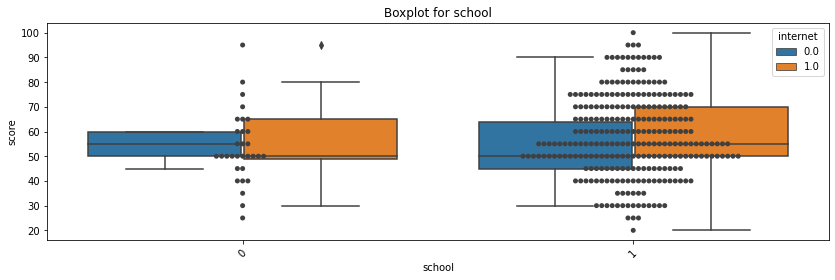

Plotting  sex


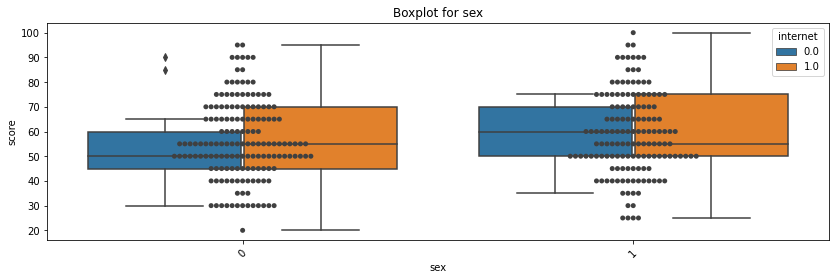

Plotting  age


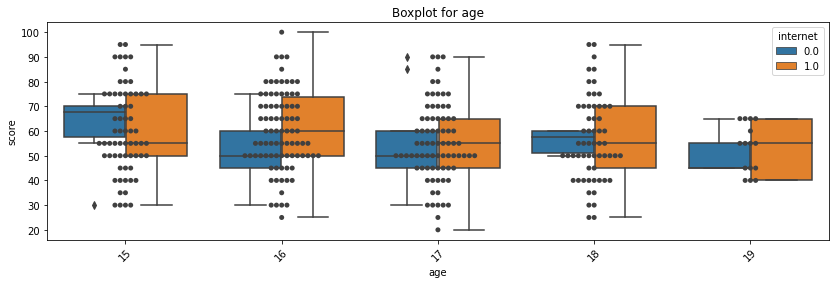

Plotting  address


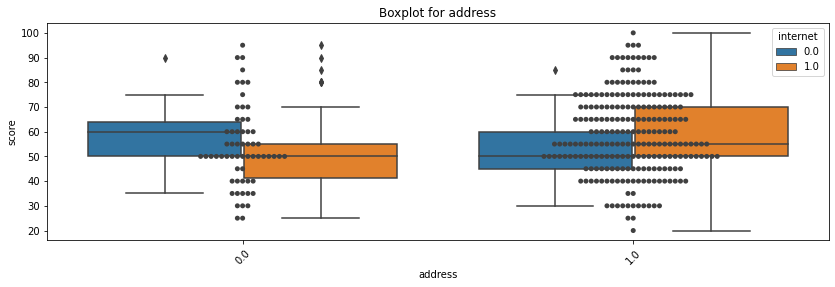

Plotting  famsize


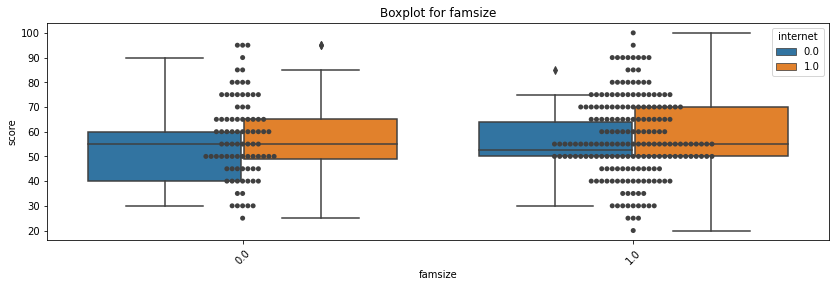

Plotting  Pstatus


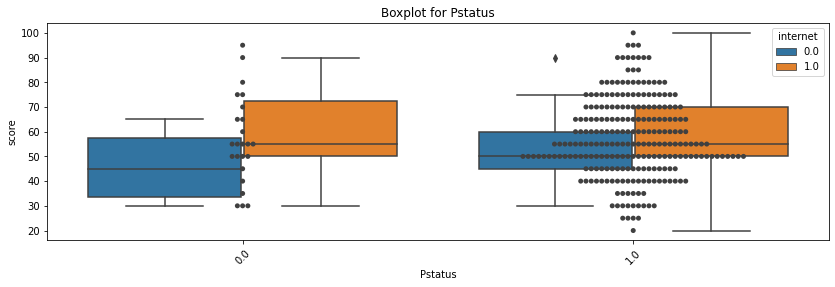

Plotting  reason


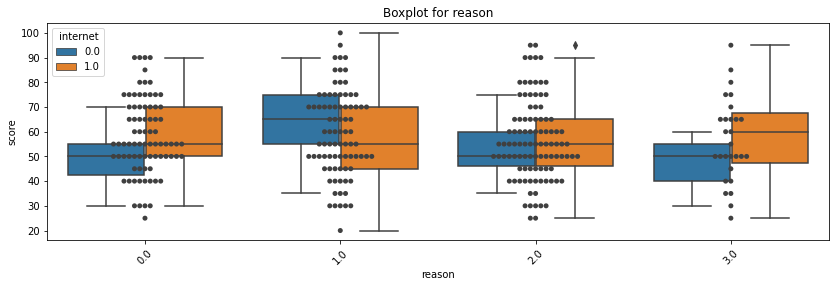

Plotting  guardian


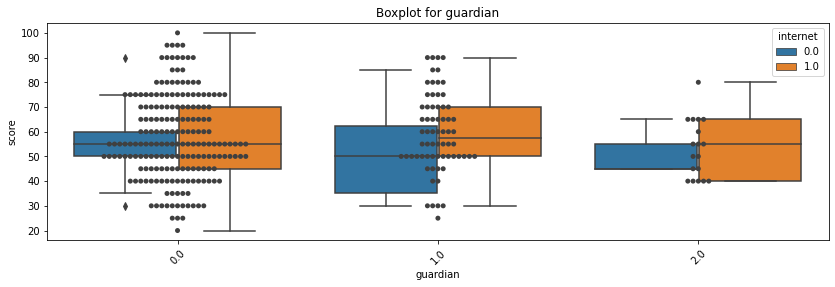

Plotting  traveltime


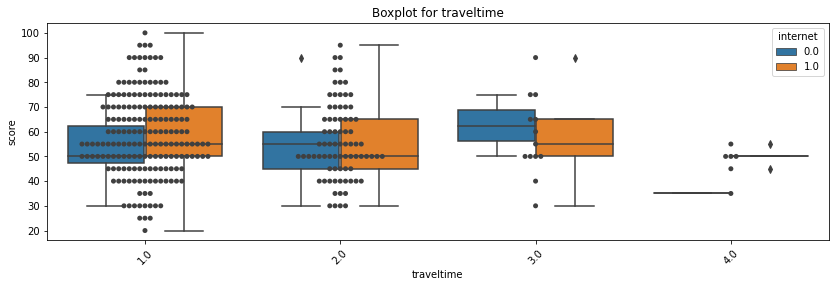

Plotting  studytime


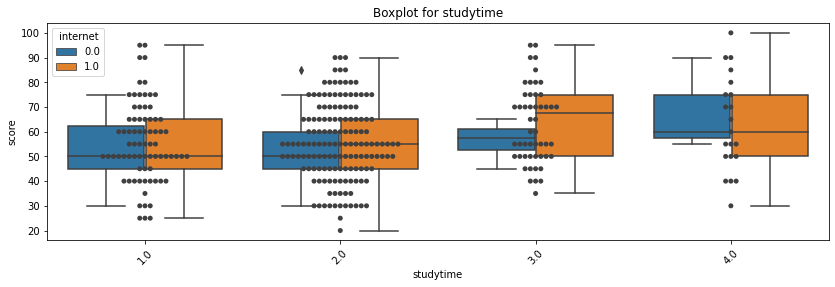

Plotting  failures


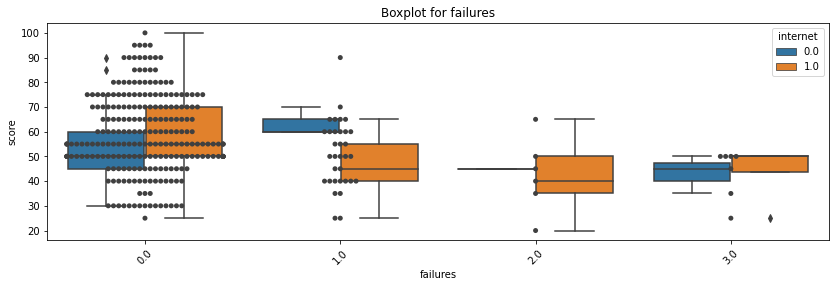

Plotting  schoolsup


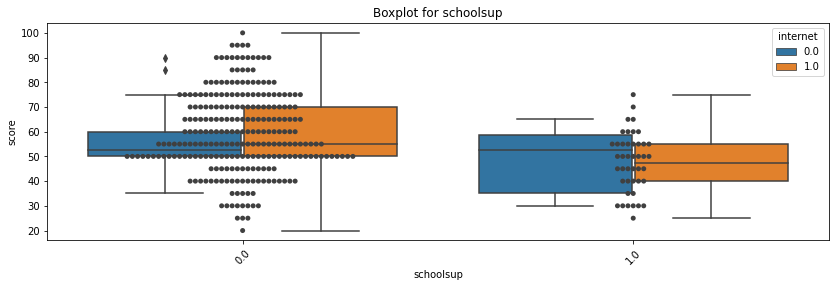

Plotting  famsup


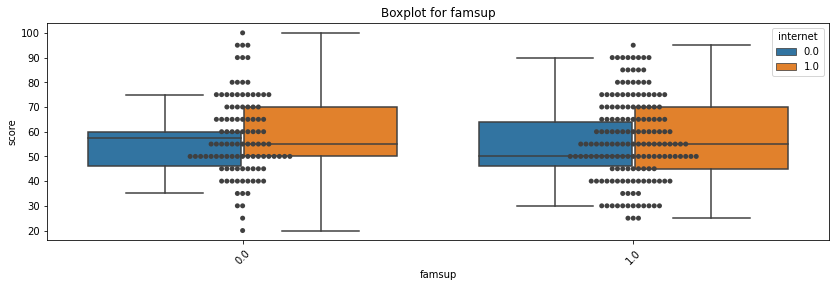

Plotting  paid


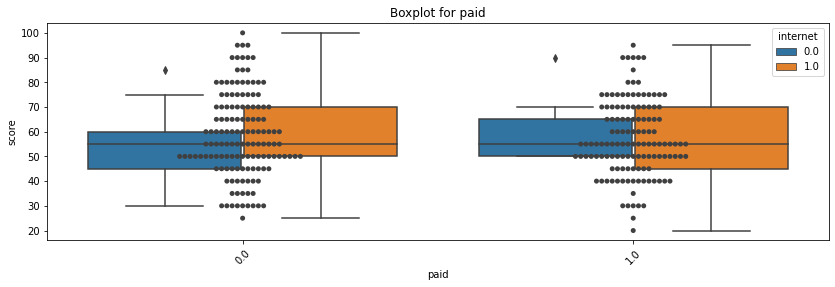

Plotting  activities


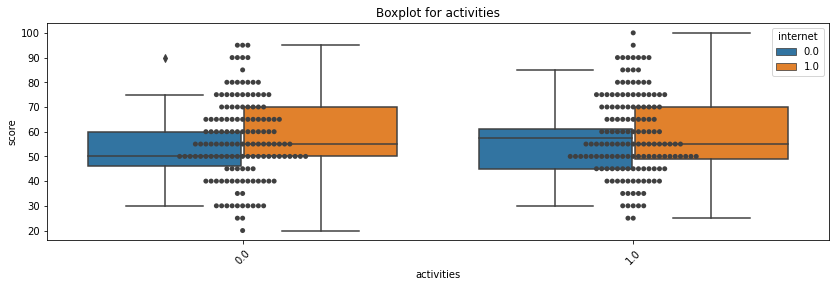

Plotting  nursery


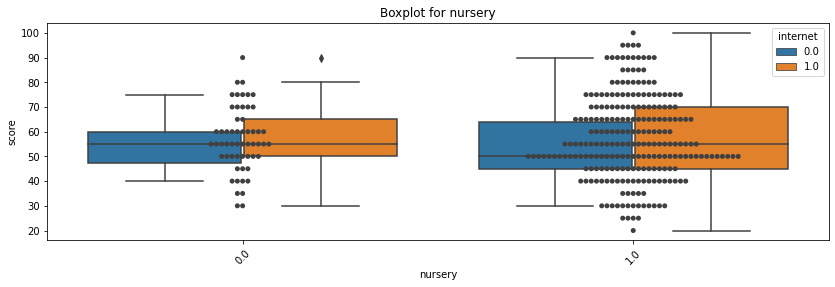

Plotting  higher


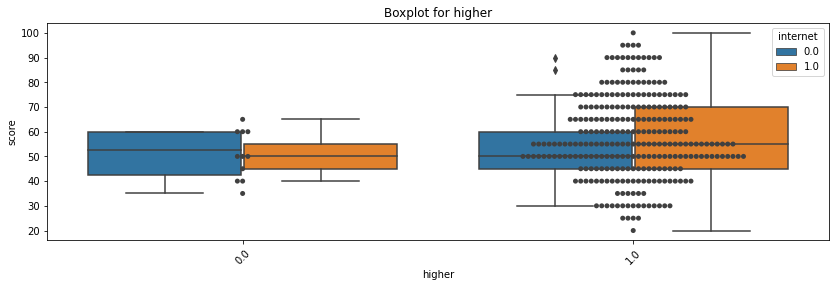

Plotting  romantic


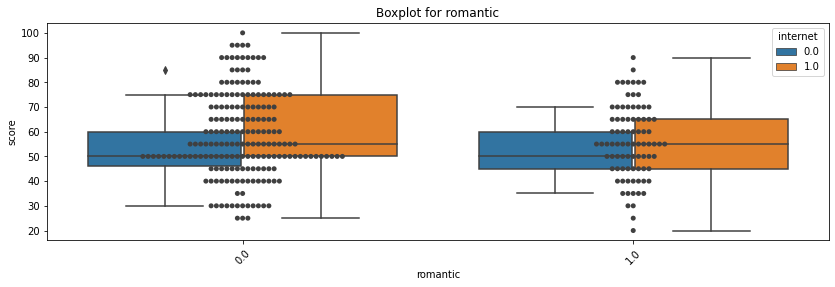

Plotting  famrel


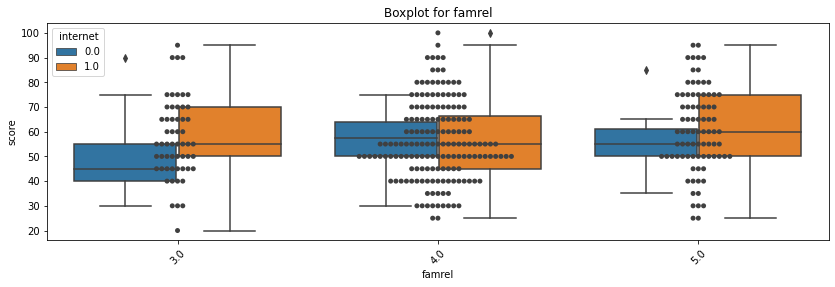

Plotting  freetime


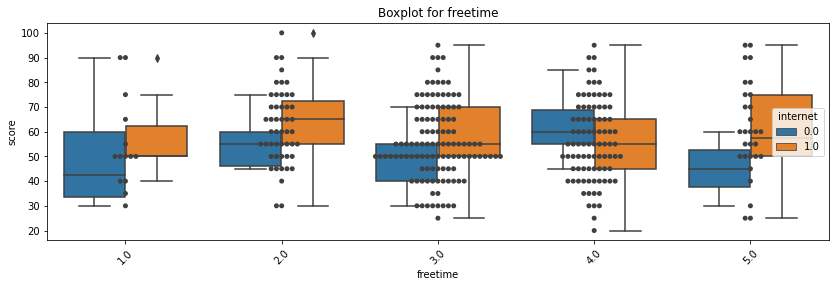

Plotting  goout


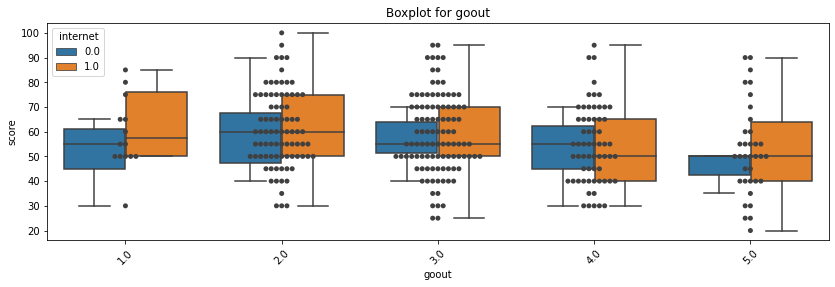

Plotting  health


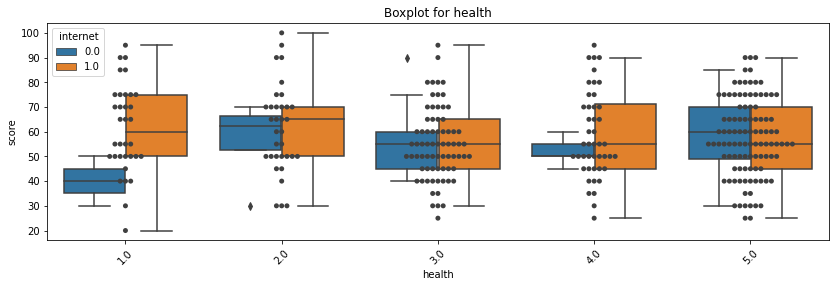

Plotting  absences


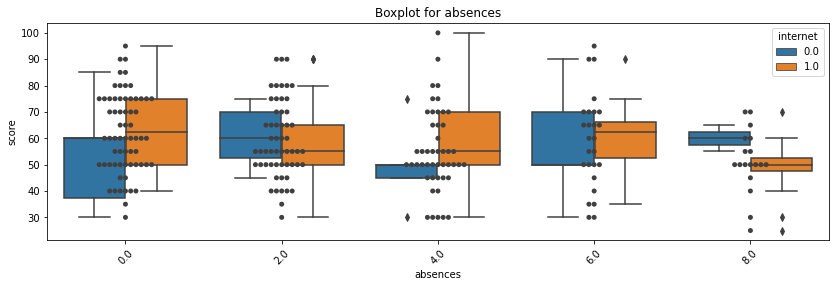

======================================== address ========================================
Plotting  school


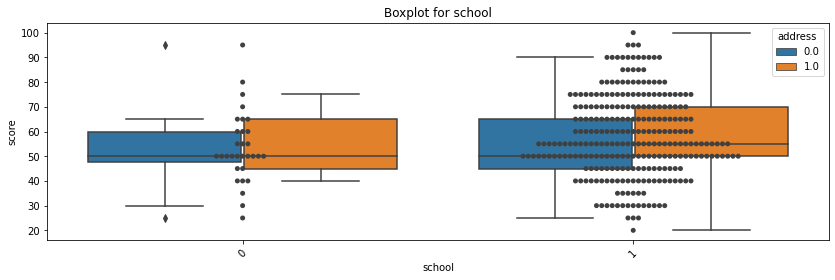

Plotting  sex


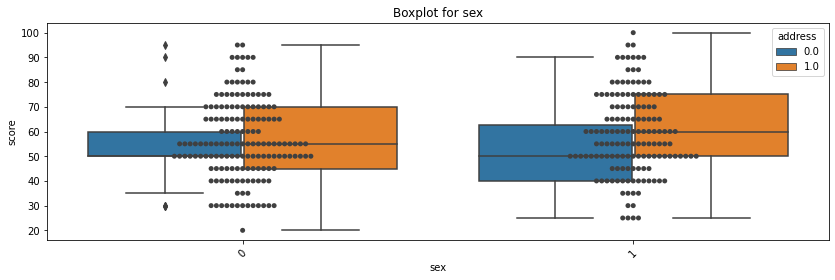

Plotting  age


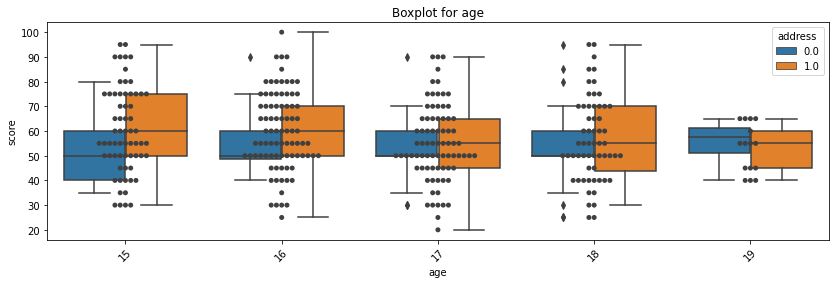

Plotting  famsize


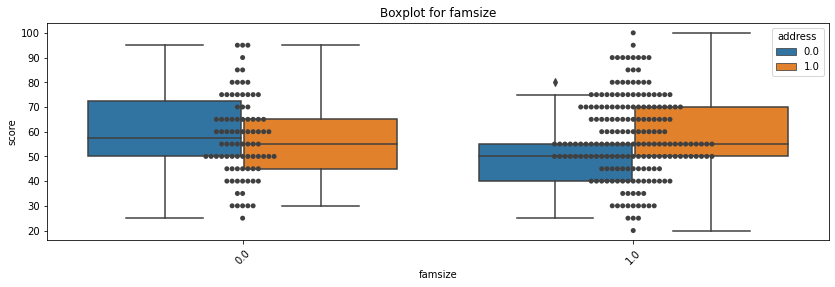

Plotting  Pstatus


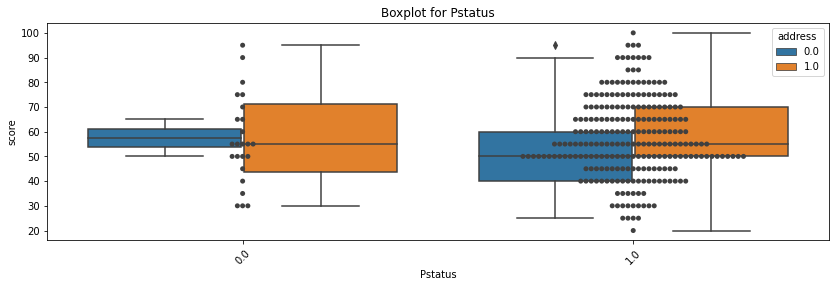

Plotting  reason


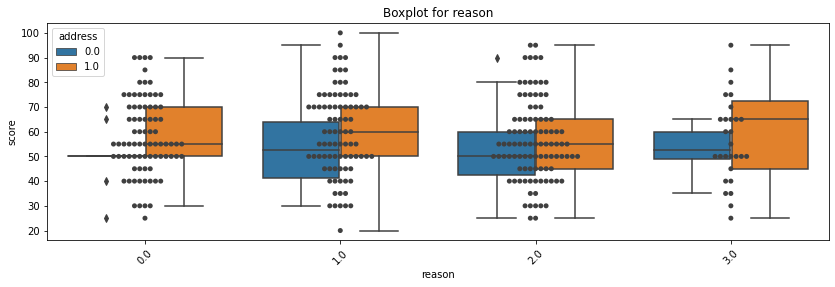

Plotting  guardian


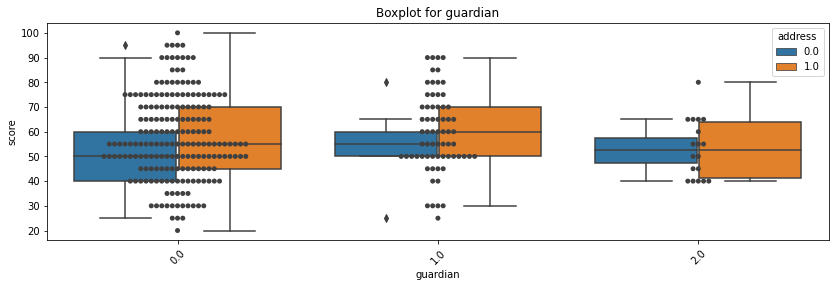

Plotting  traveltime


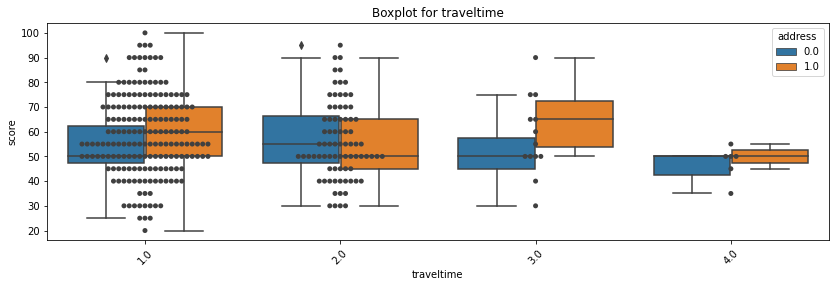

Plotting  studytime


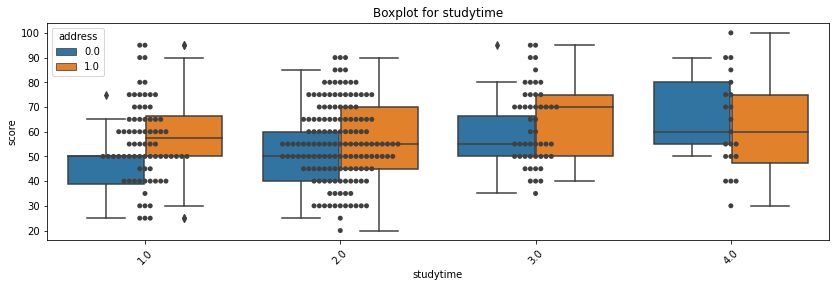

Plotting  failures


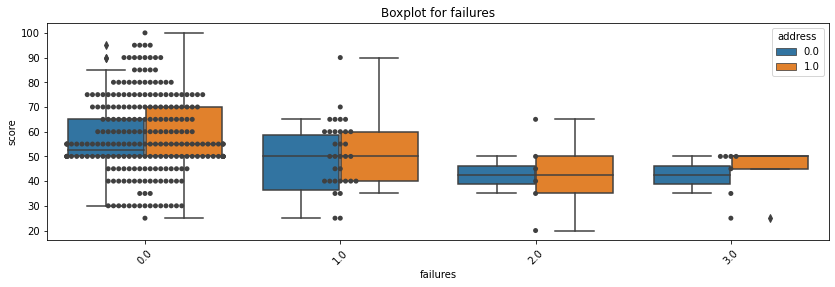

Plotting  schoolsup


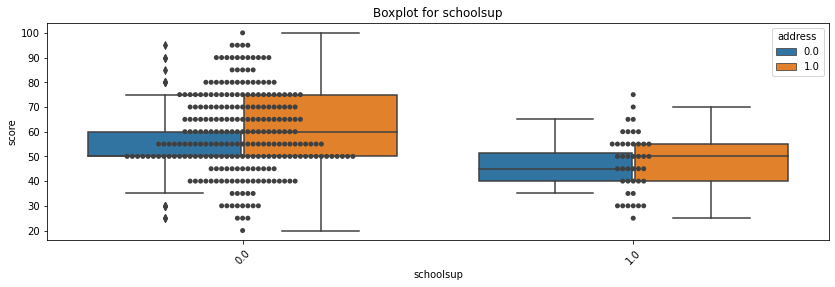

Plotting  famsup


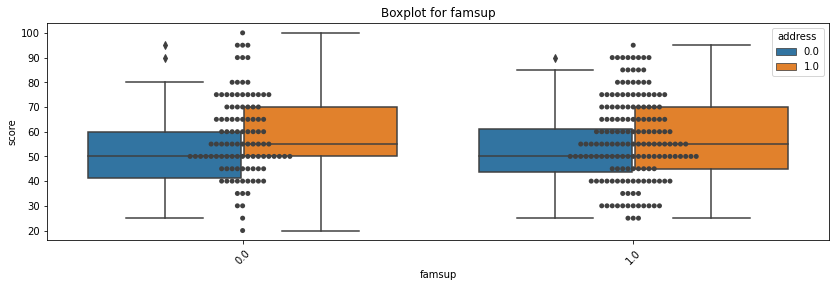

Plotting  paid


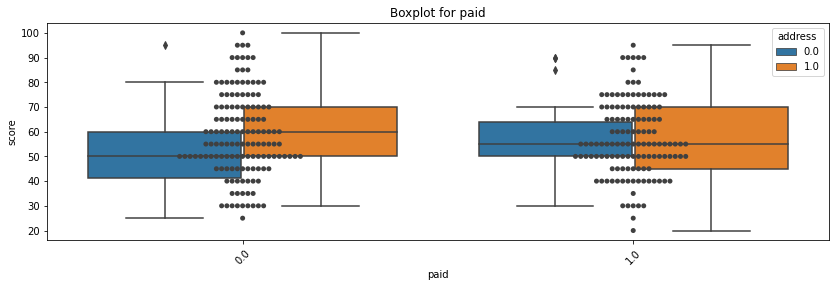

Plotting  activities


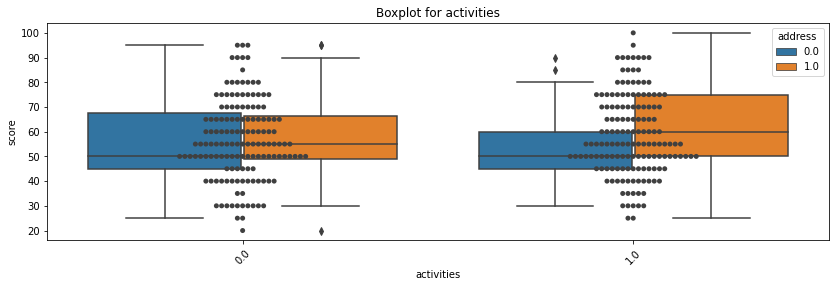

Plotting  nursery


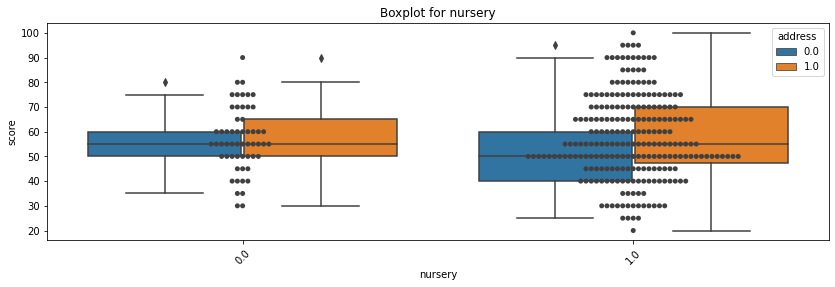

Plotting  higher


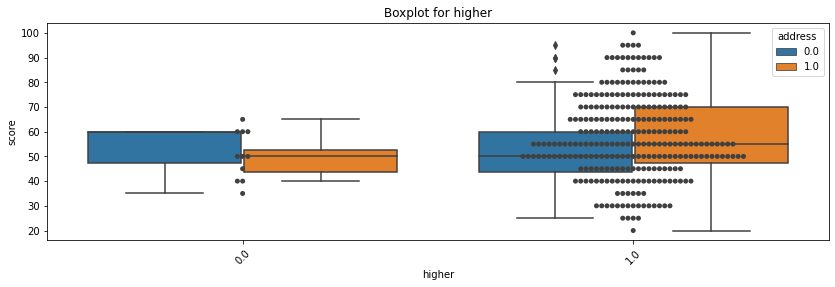

Plotting  internet


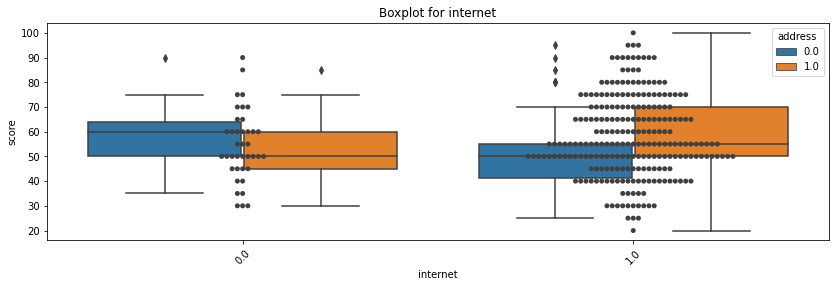

Plotting  romantic


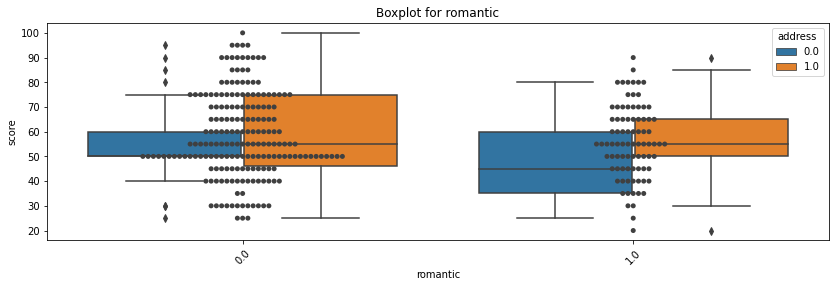

Plotting  famrel


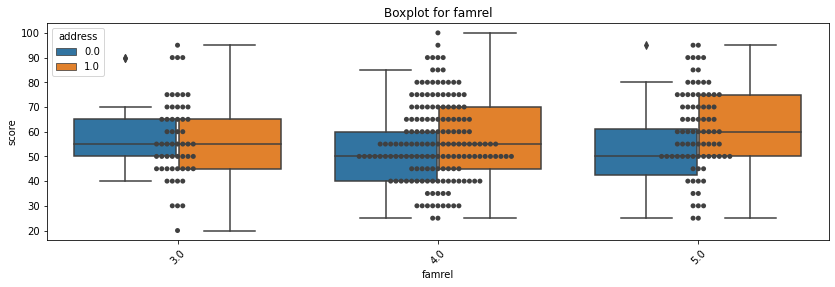

Plotting  freetime


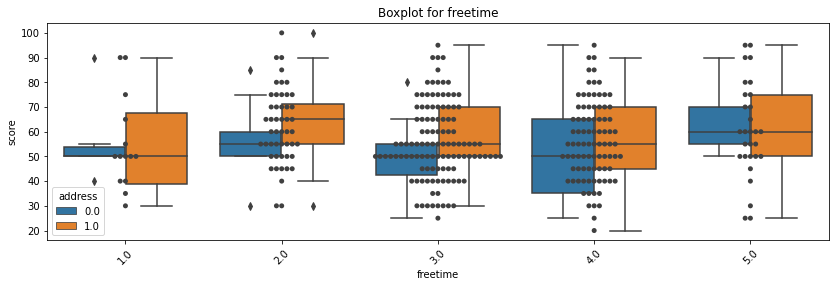

Plotting  goout


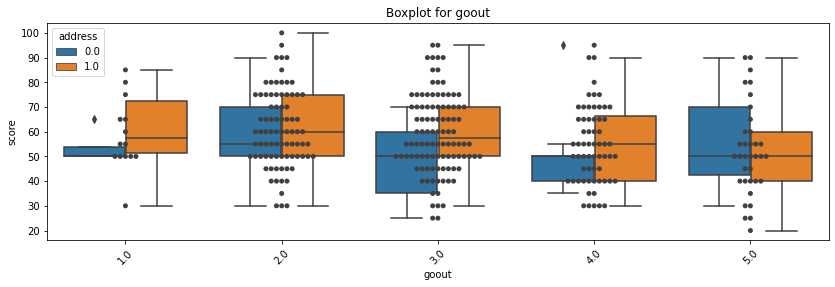

Plotting  health


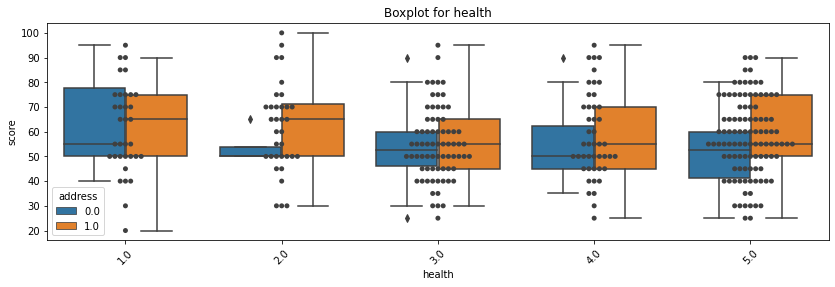

Plotting  absences


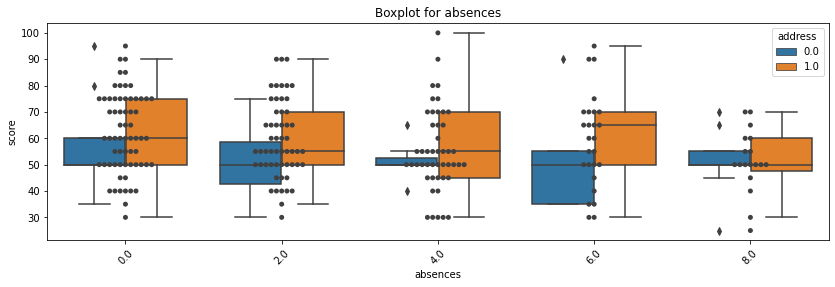

======================================== famsup ========================================
Plotting  school


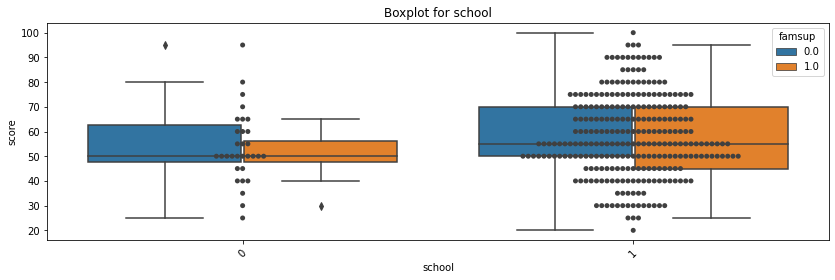

Plotting  sex


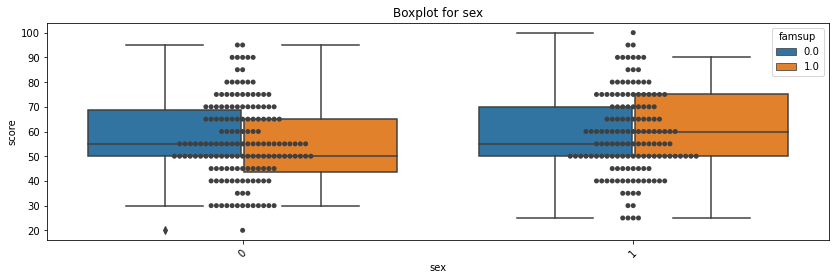

Plotting  age


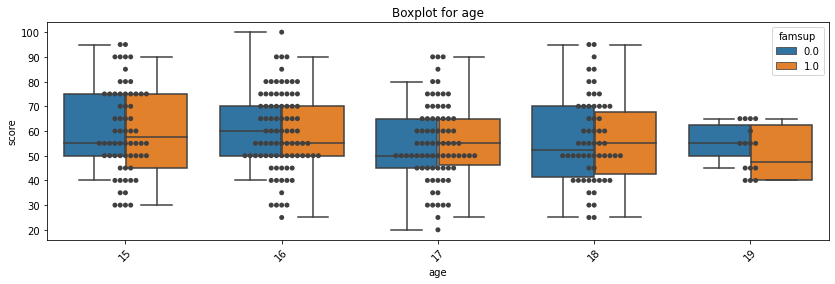

Plotting  address


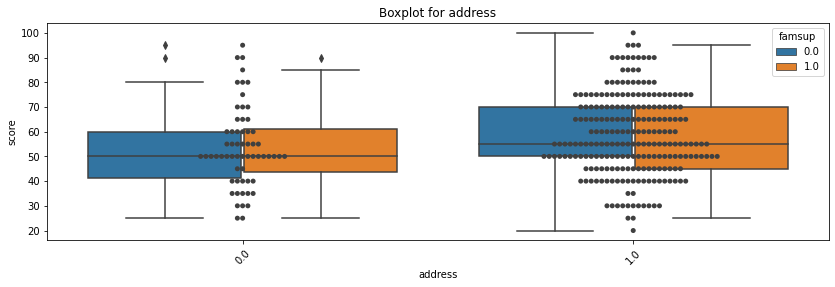

Plotting  famsize


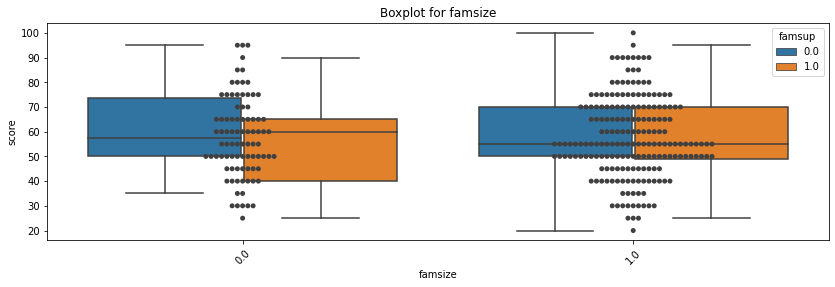

Plotting  Pstatus


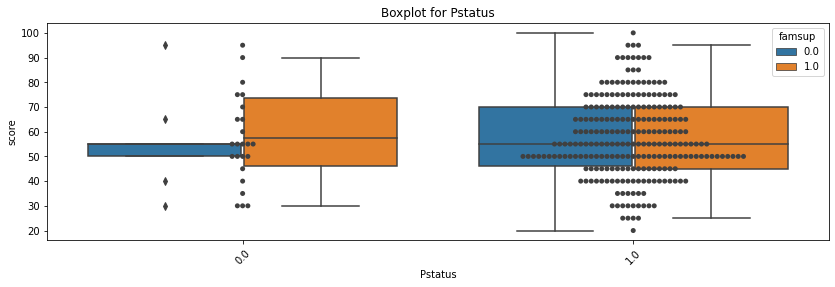

Plotting  reason


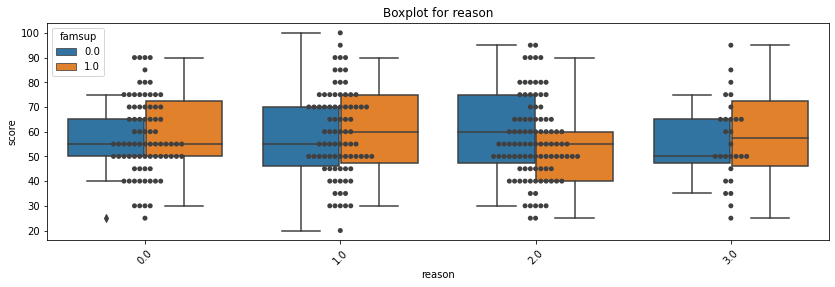

Plotting  guardian


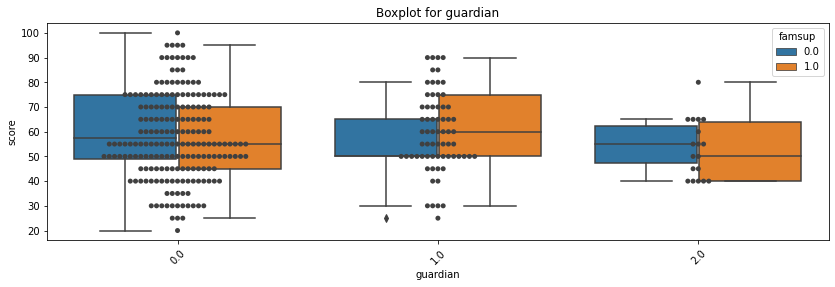

Plotting  traveltime


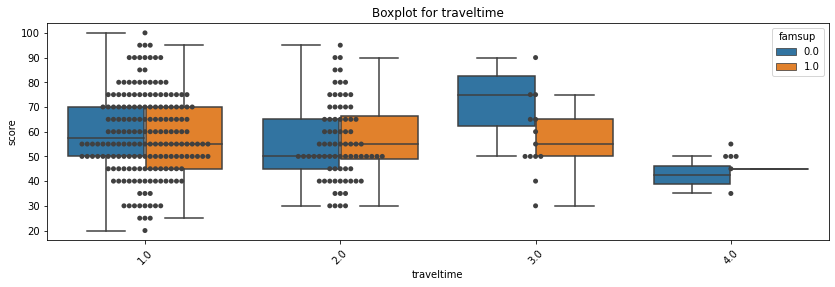

Plotting  studytime


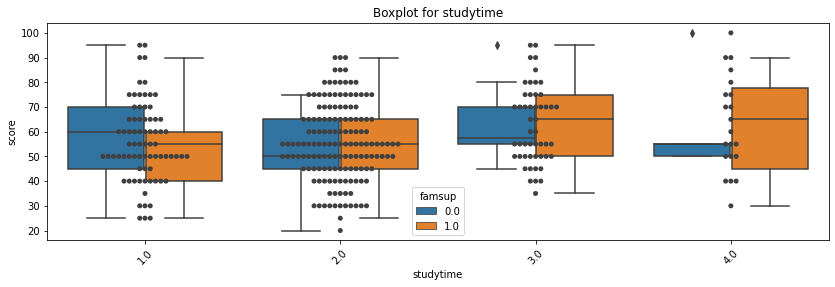

Plotting  failures


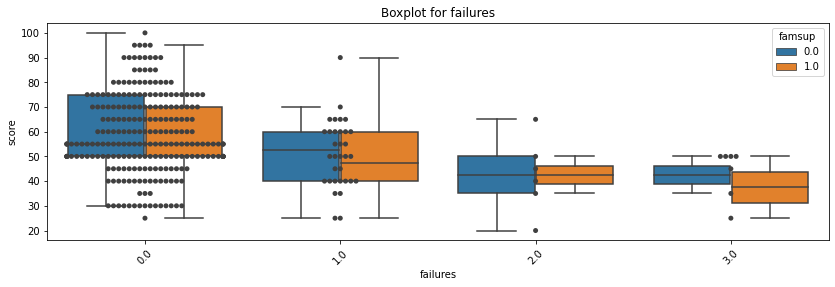

Plotting  schoolsup


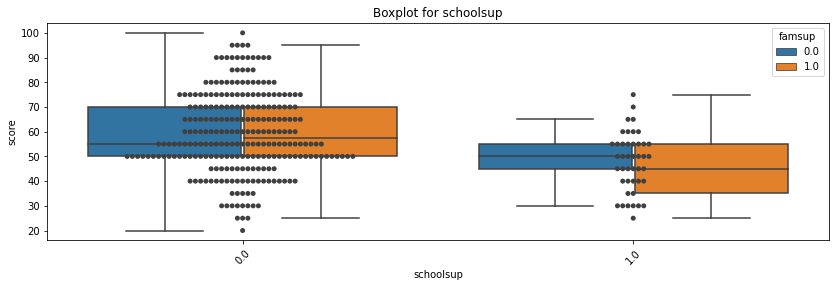

Plotting  paid


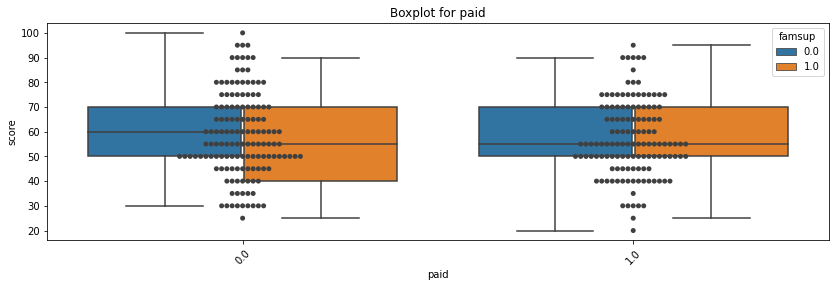

Plotting  activities


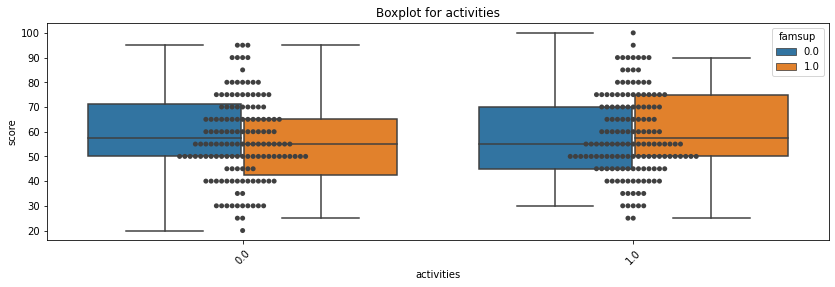

Plotting  nursery


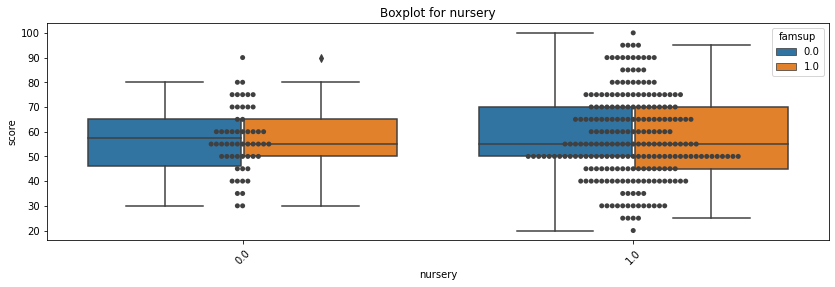

Plotting  higher


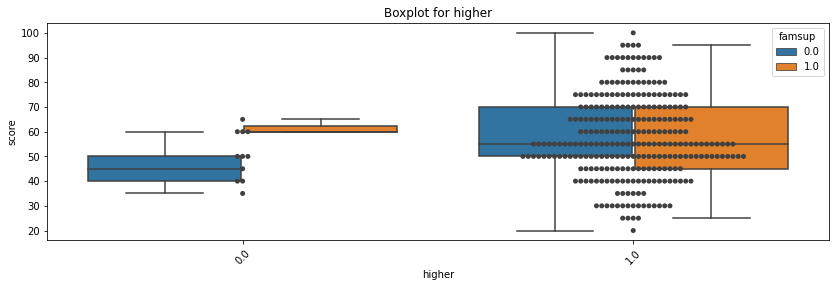

Plotting  internet


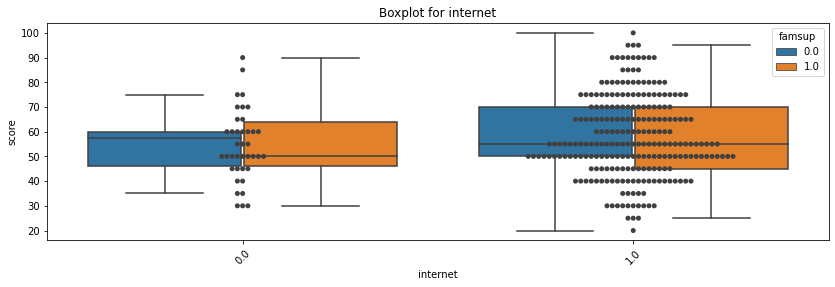

Plotting  romantic


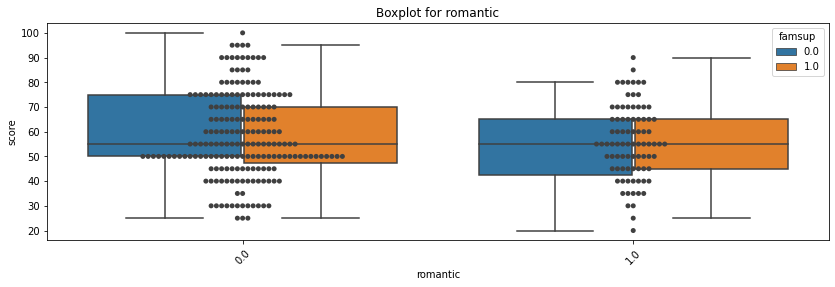

Plotting  famrel


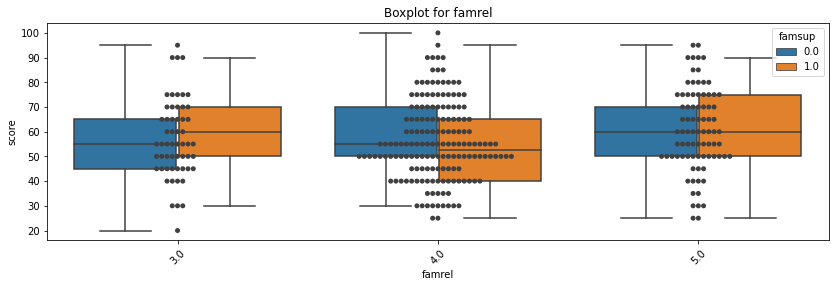

Plotting  freetime


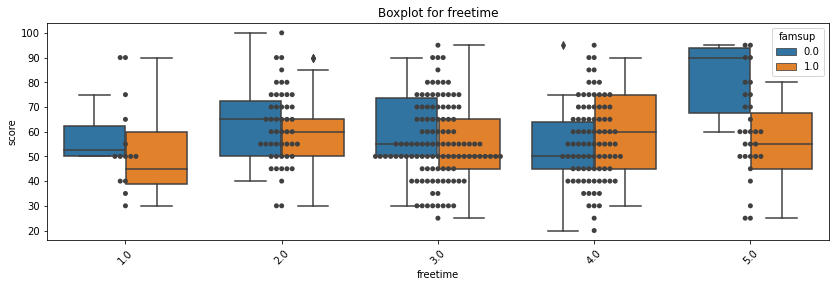

Plotting  goout


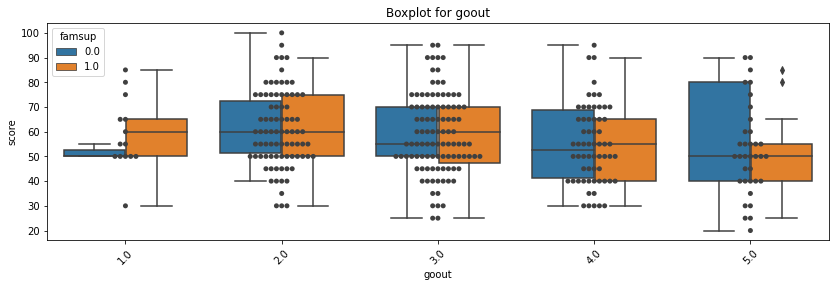

Plotting  health


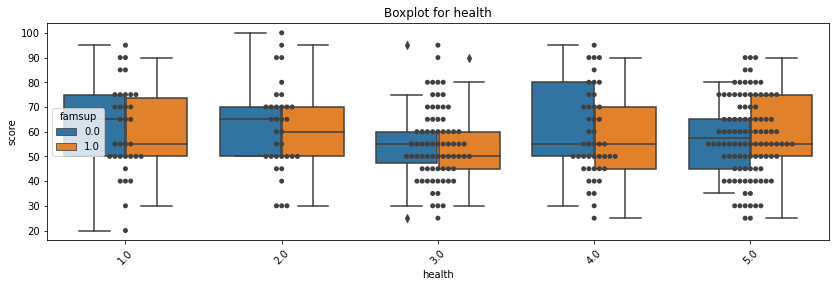

Plotting  absences


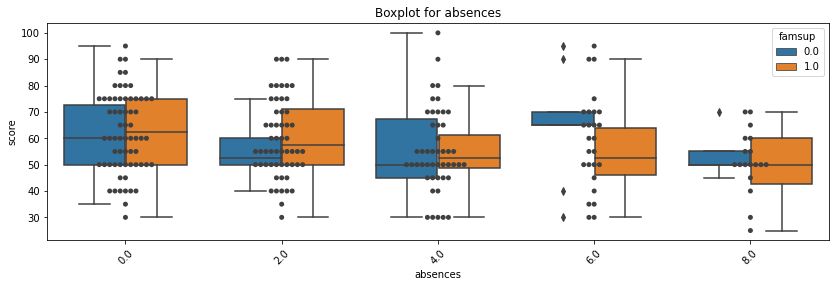

In [339]:
# Проверим ещё пару вариантов комбинаций
hues = ['nursery', 'internet', 'address', 'famsup']
# В слух не произносить  
for hue in hues:
    print('='*40, hue, '='*40)
    for column in df_nonzero_score.columns:
        if column == 'score' or column == hue:
            continue
        get_boxplot(df=df_nonzero_score, column=column, y='score', hue=hue)

Plotting  school


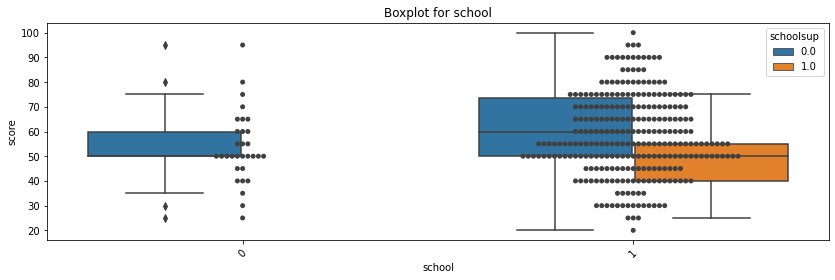

Plotting  sex


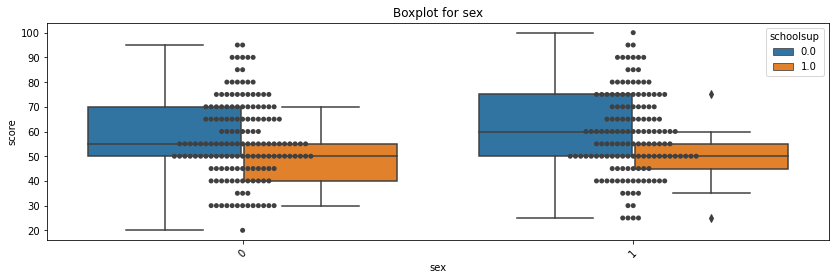

Plotting  age


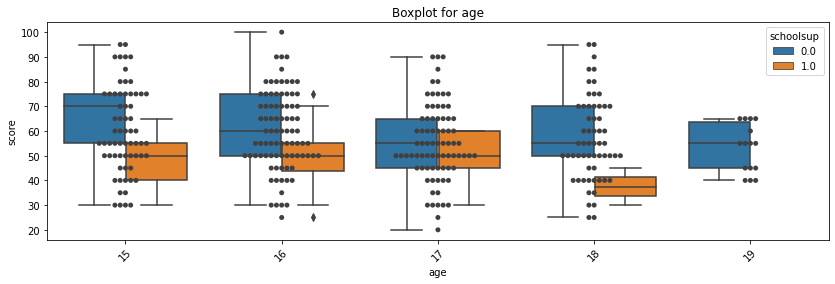

Plotting  address


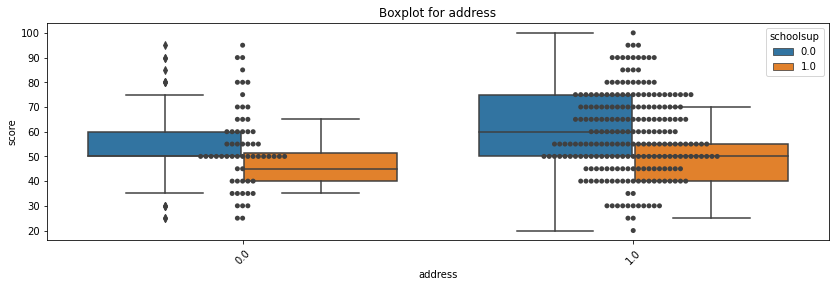

Plotting  famsize


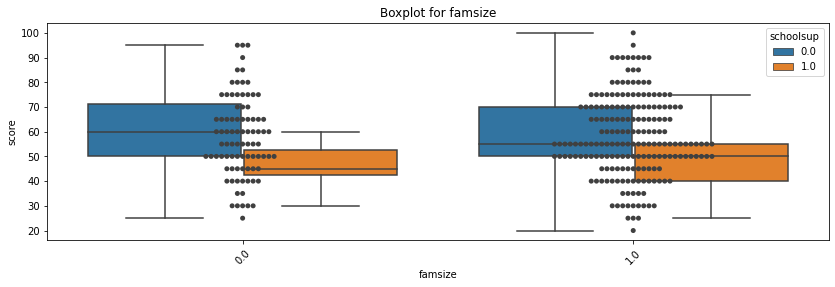

Plotting  Pstatus


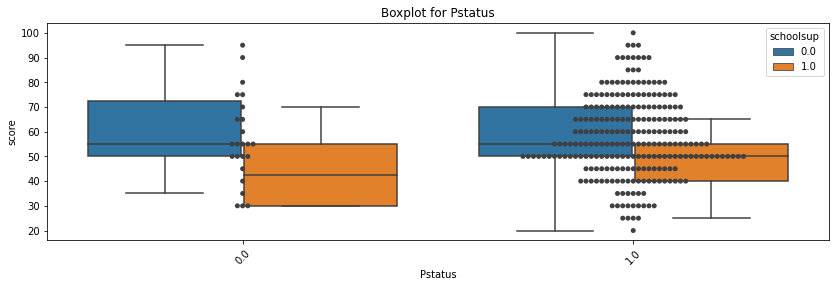

Plotting  reason


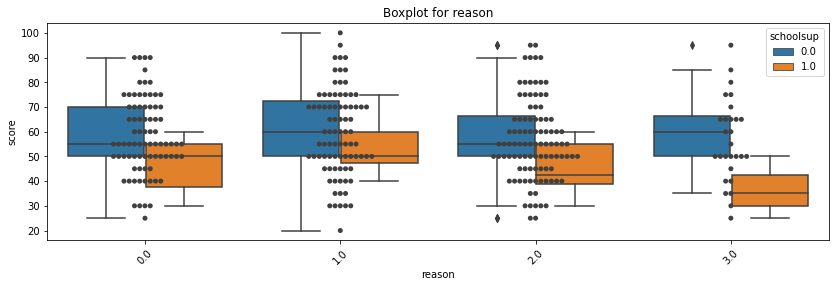

Plotting  guardian


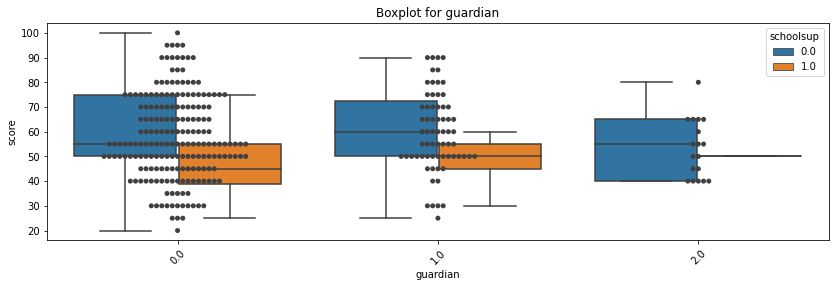

Plotting  traveltime


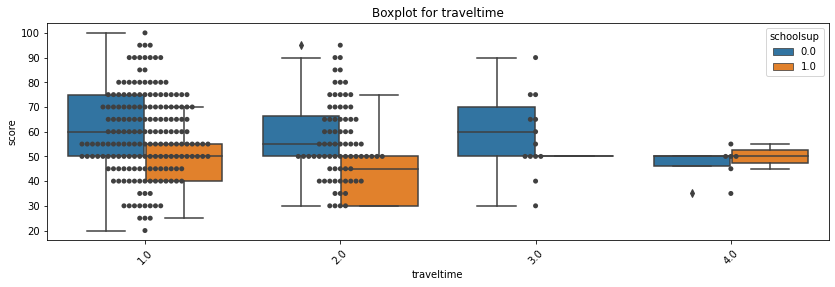

Plotting  studytime


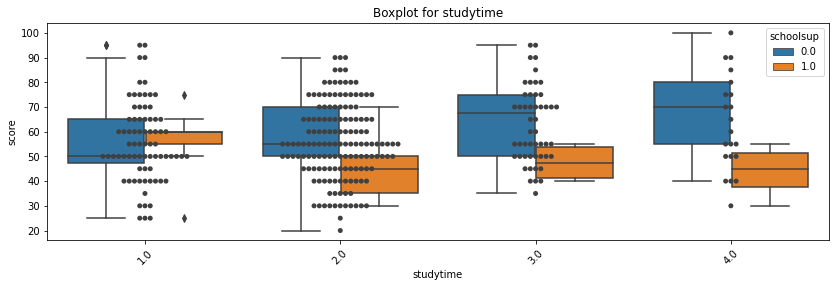

Plotting  failures


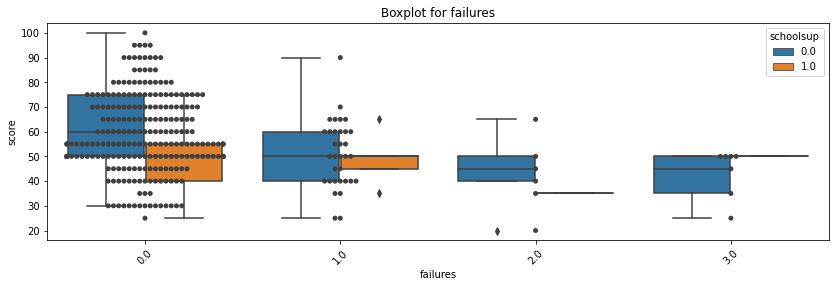

Plotting  famsup


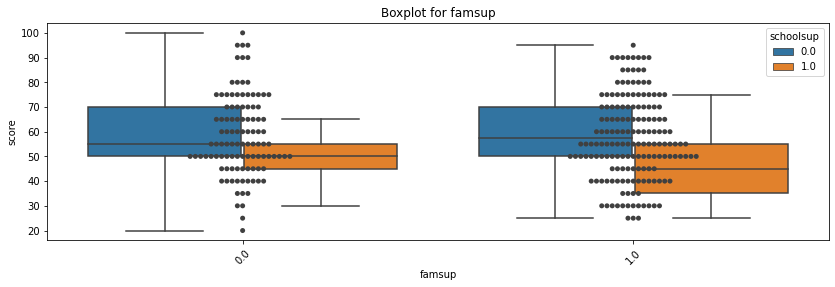

Plotting  paid


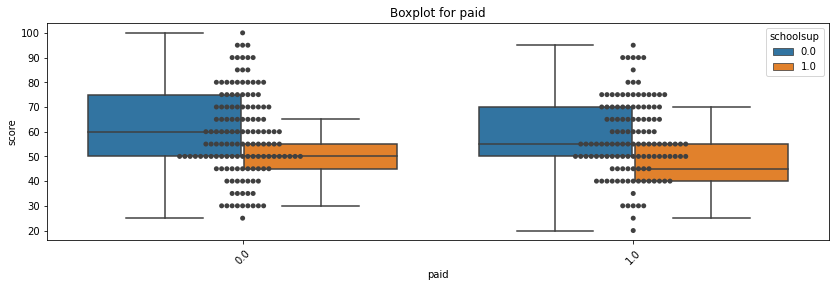

Plotting  activities


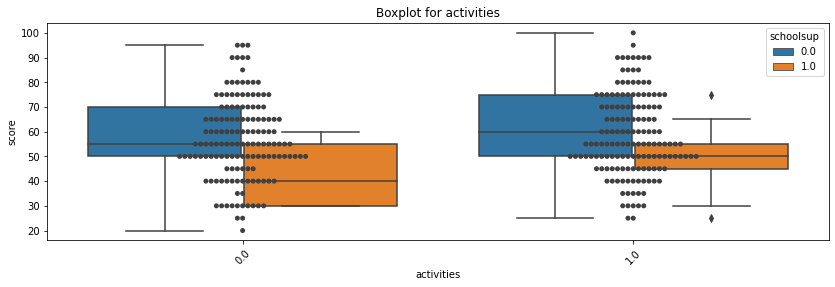

Plotting  nursery


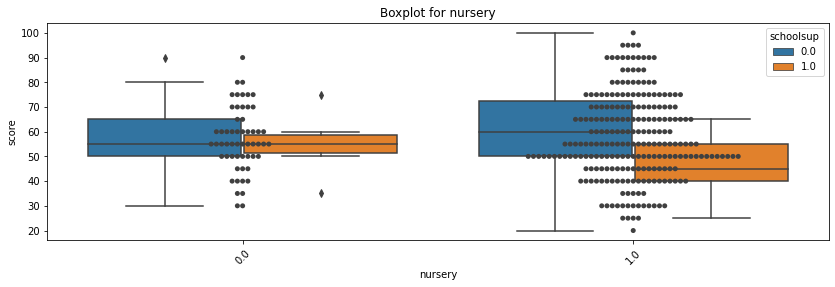

Plotting  higher


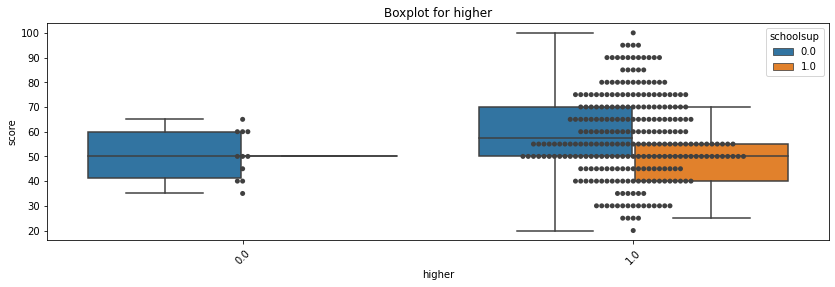

Plotting  internet


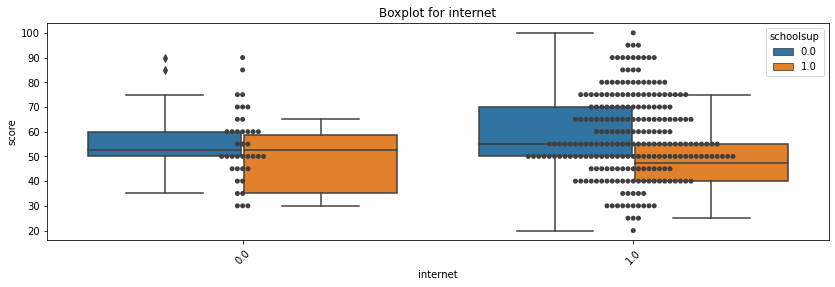

Plotting  romantic


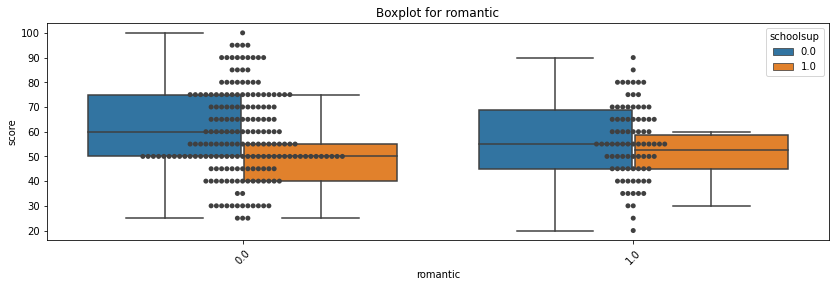

Plotting  famrel


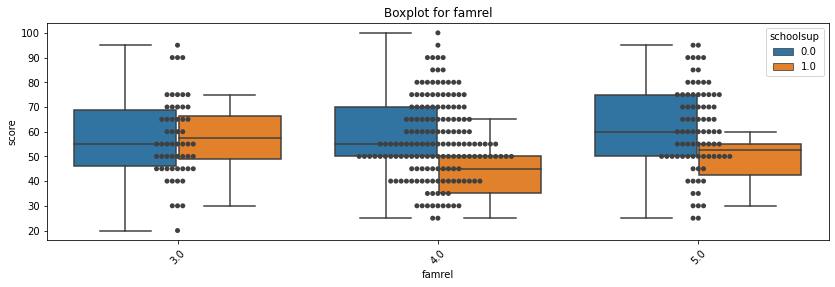

Plotting  freetime


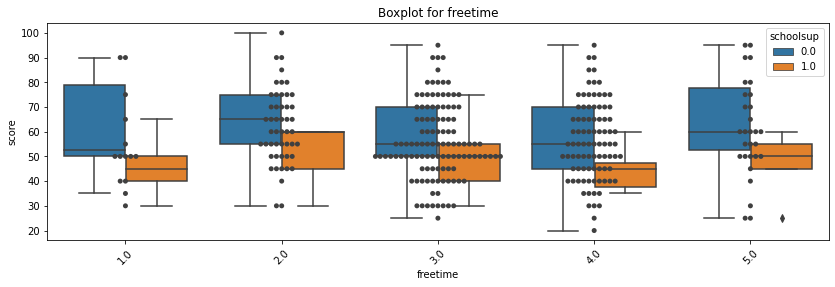

Plotting  goout


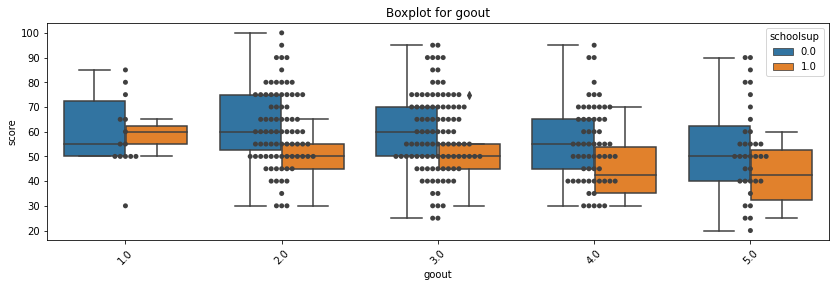

Plotting  health


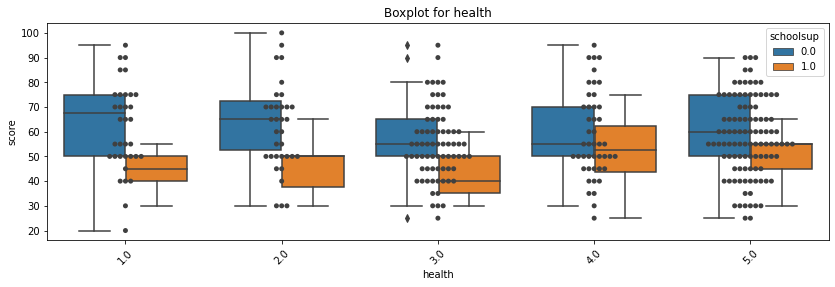

Plotting  absences


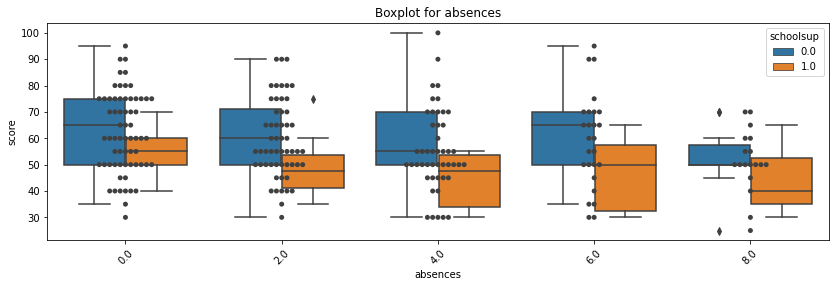

In [340]:
# 'schoolsup' ярко выраженное негативное влияние на успеваемость
for column in df_nonzero_score.columns:
    if column == 'score' or column=='schoolsup':
        continue
    get_boxplot(df=df_nonzero_score, column=column, y='score', hue='schoolsup')

Plotting  school


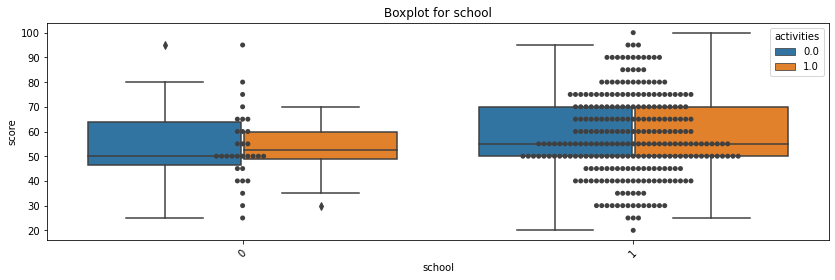

Plotting  sex


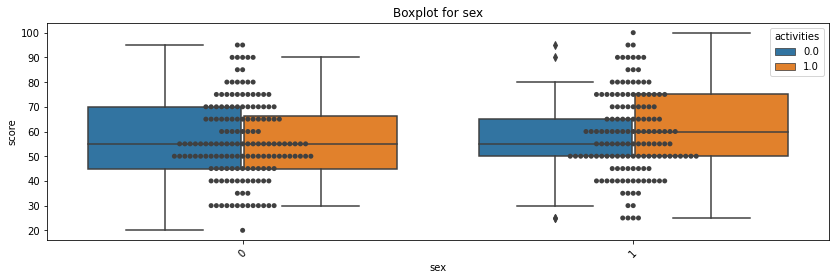

Plotting  age


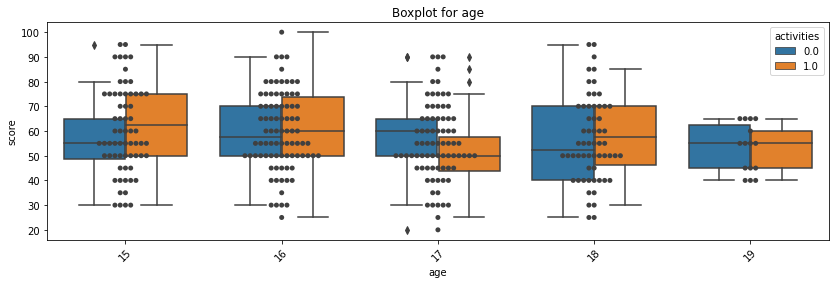

Plotting  address


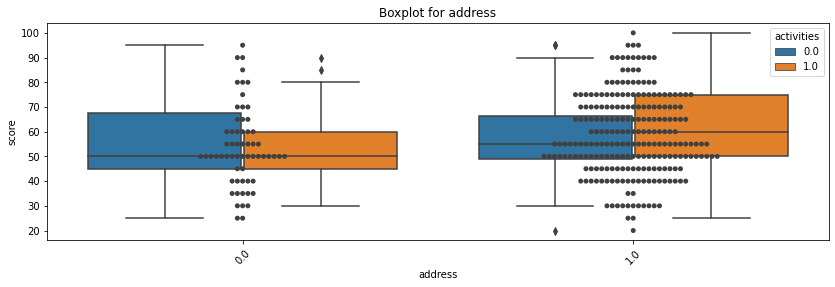

Plotting  famsize


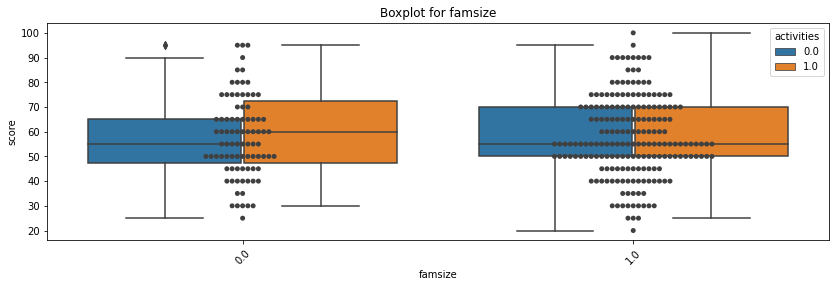

Plotting  Pstatus


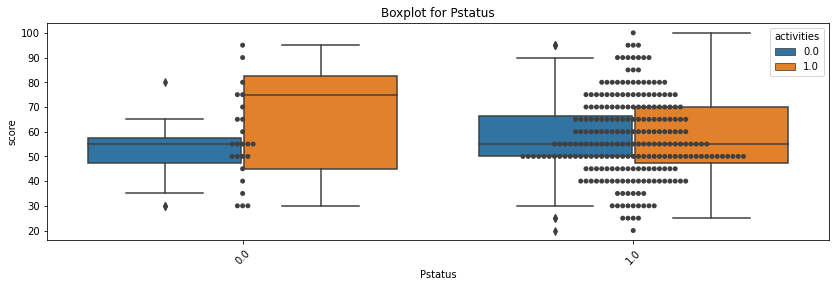

Plotting  reason


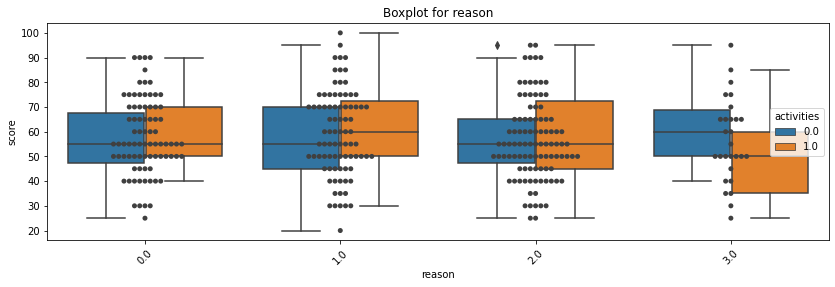

Plotting  guardian


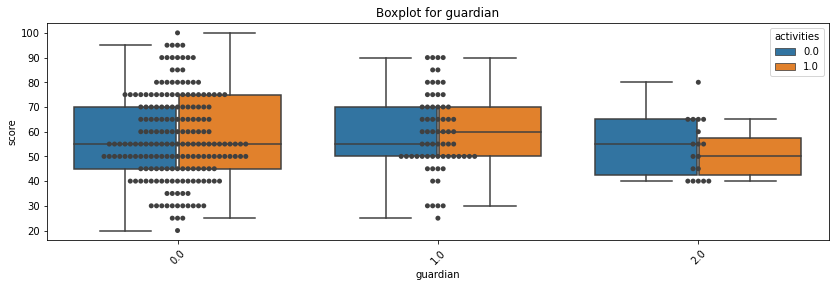

Plotting  traveltime


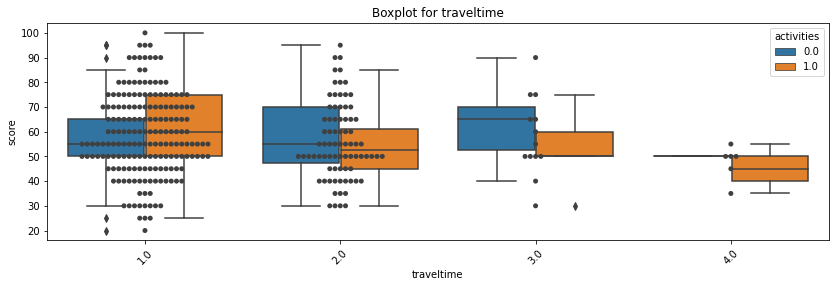

Plotting  studytime


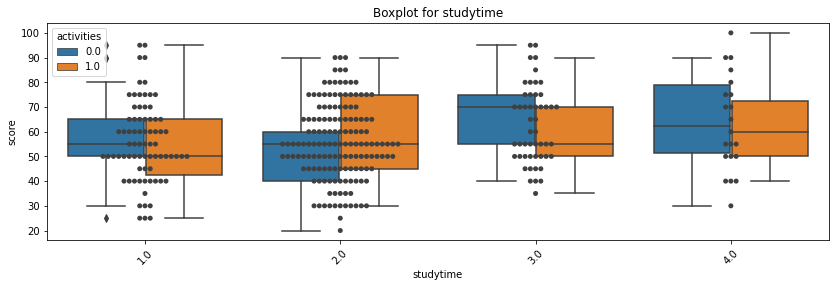

Plotting  failures


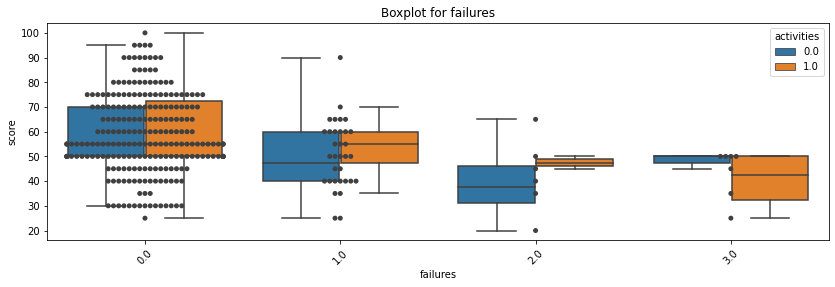

Plotting  schoolsup


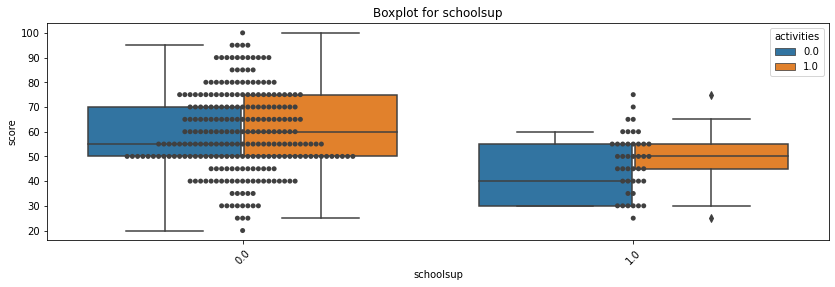

Plotting  famsup


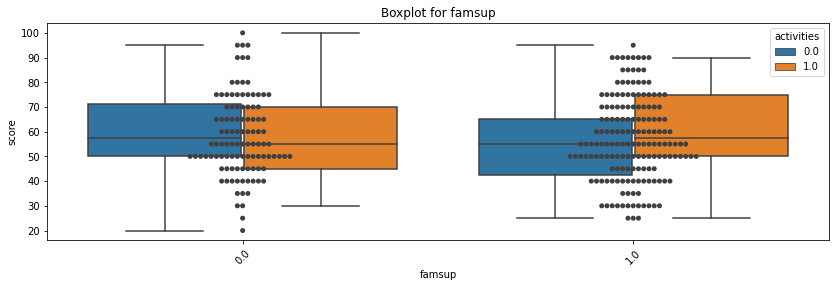

Plotting  paid


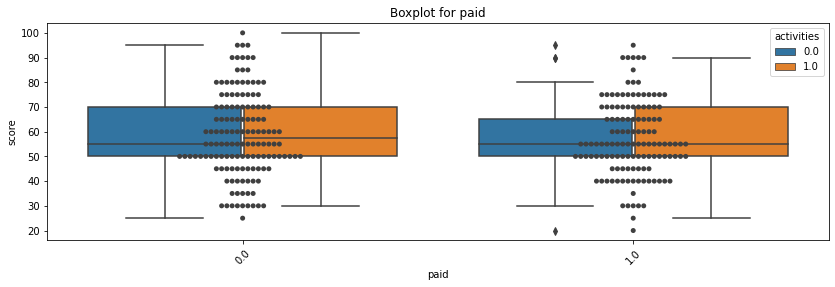

Plotting  nursery


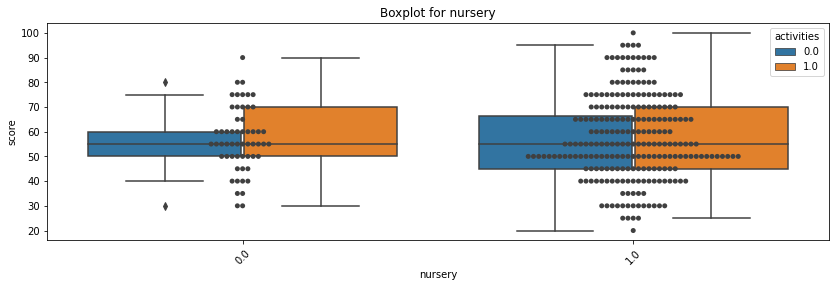

Plotting  higher


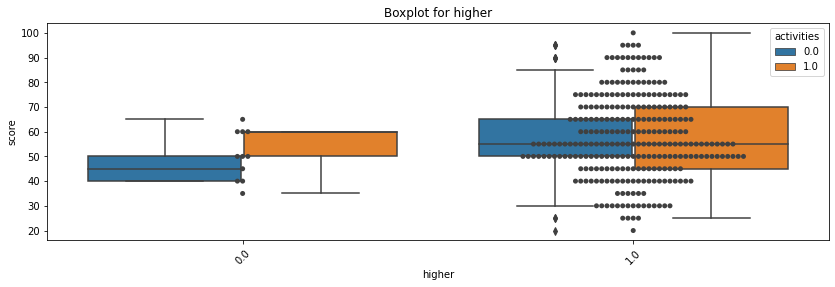

Plotting  internet


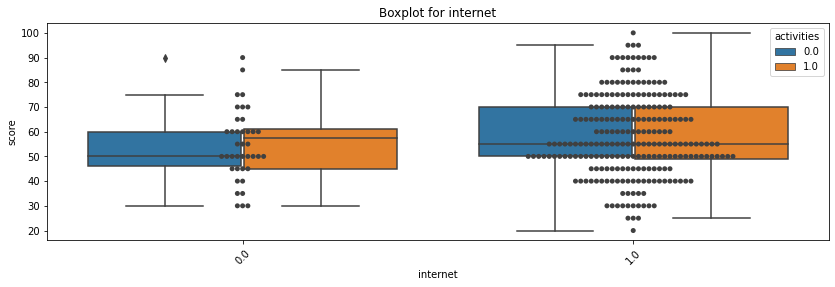

Plotting  romantic


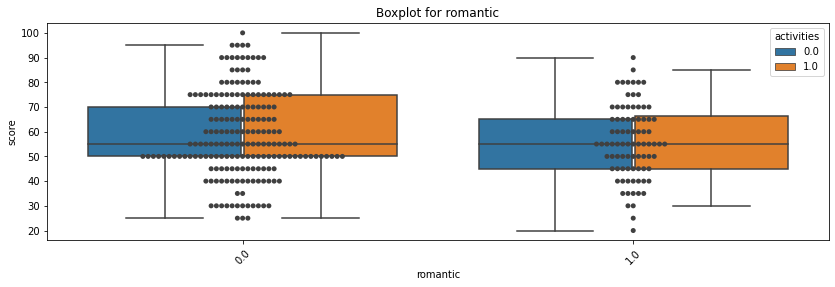

Plotting  famrel


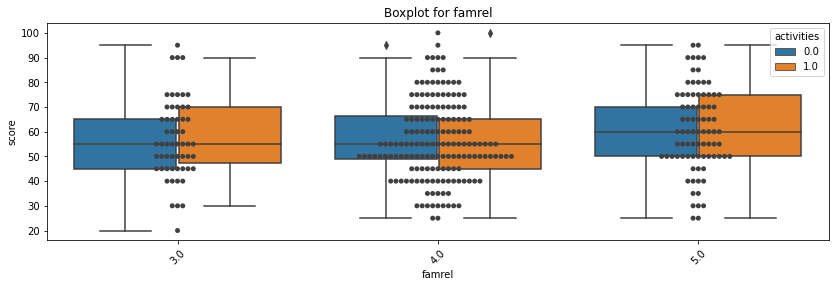

Plotting  freetime


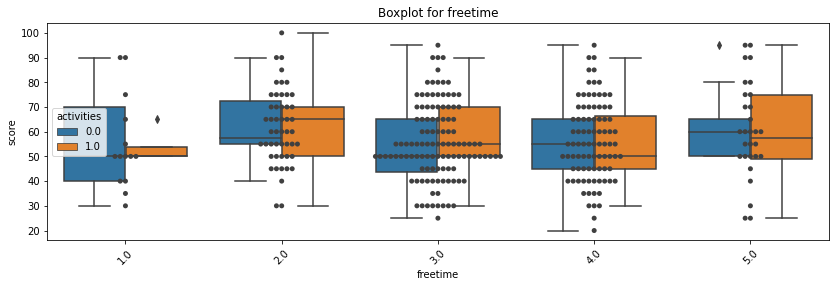

Plotting  goout


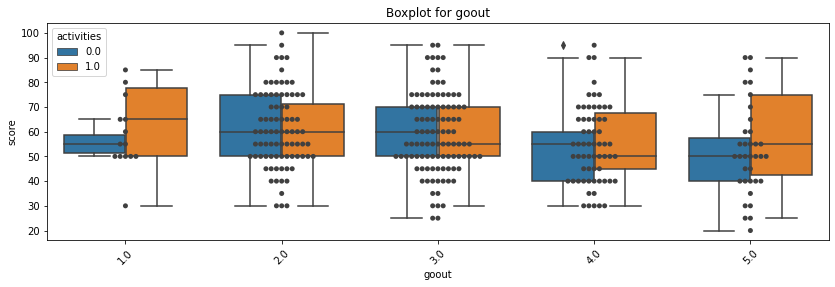

Plotting  health


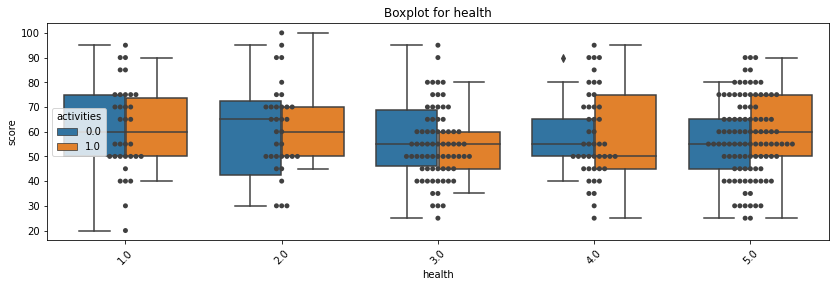

Plotting  absences


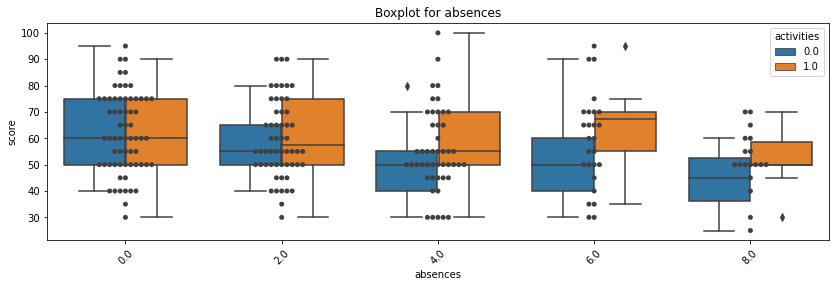

In [341]:
# 'Activities' не просматривается ярко выраженной зависимости
for column in df_nonzero_score.columns:
    if column == 'score' or column=='activities':
        continue
    get_boxplot(df=df_nonzero_score, column=column, y='score', hue='activities')

Plotting  school


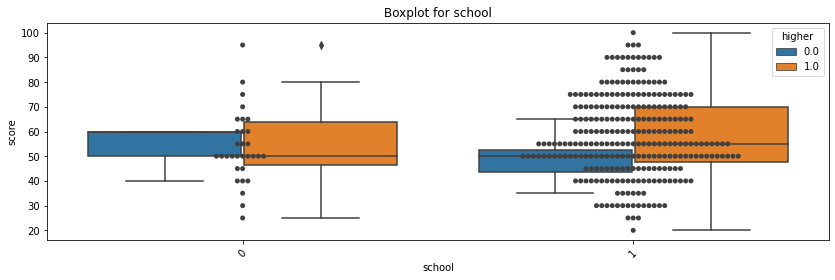

Plotting  sex


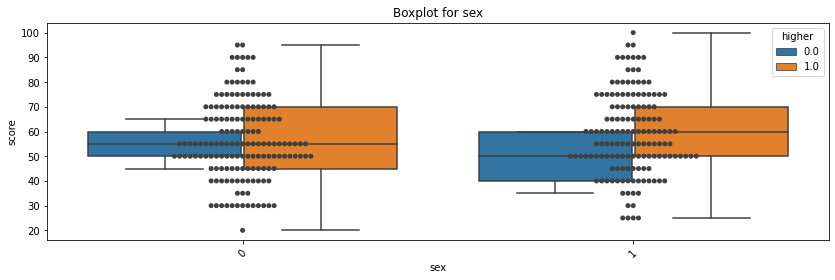

Plotting  age


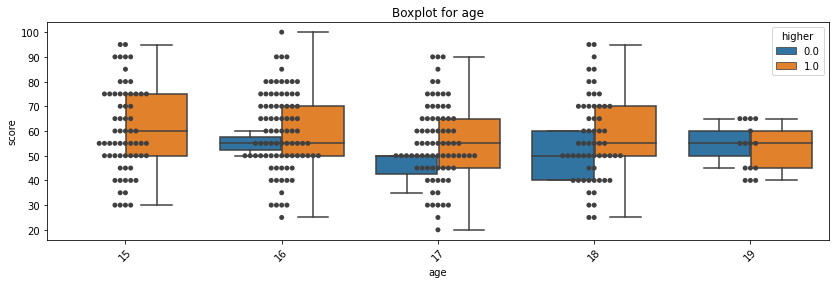

Plotting  address


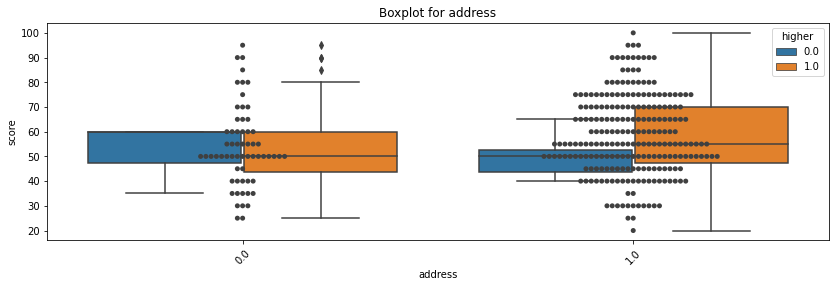

Plotting  famsize


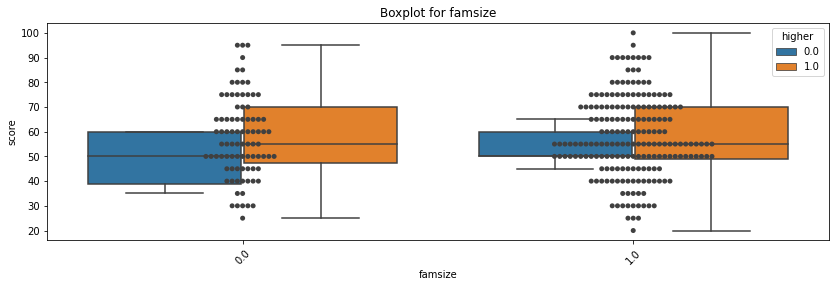

Plotting  Pstatus


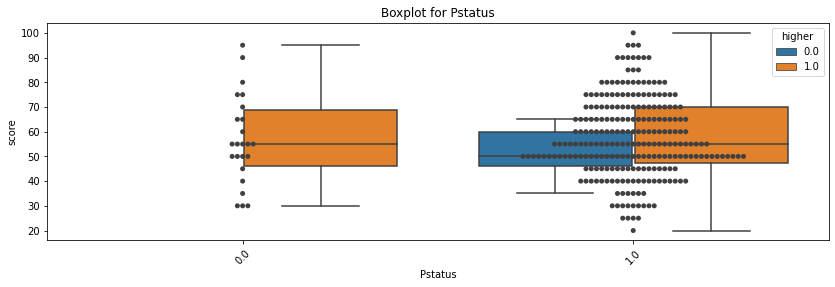

Plotting  reason


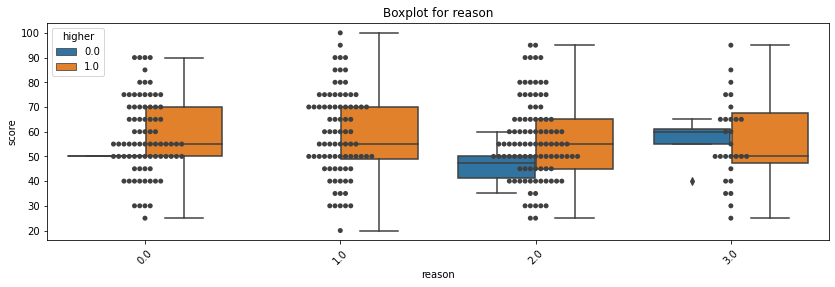

Plotting  guardian


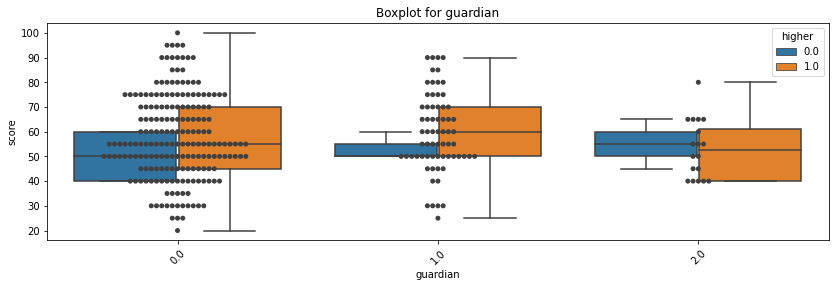

Plotting  traveltime


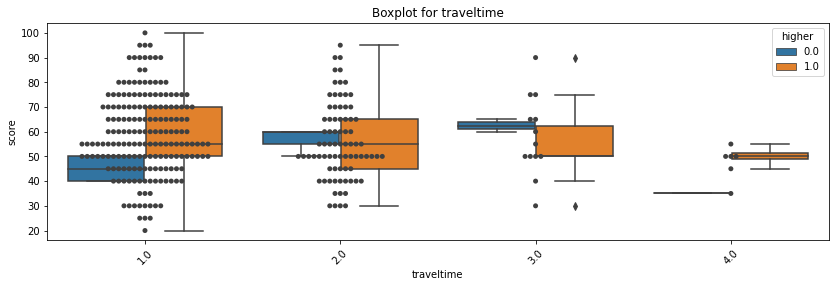

Plotting  studytime


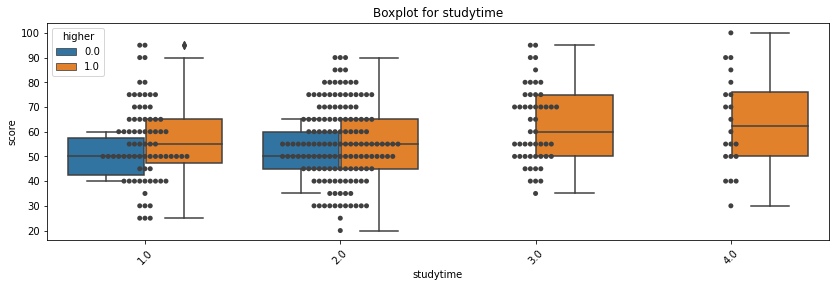

Plotting  failures


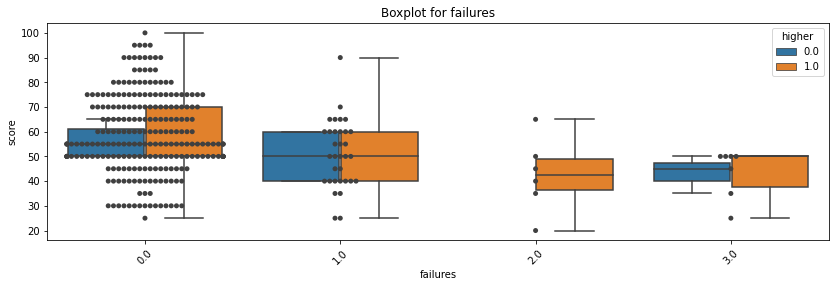

Plotting  schoolsup


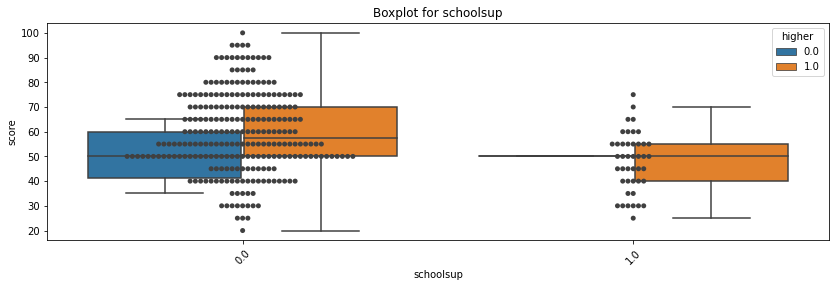

Plotting  famsup


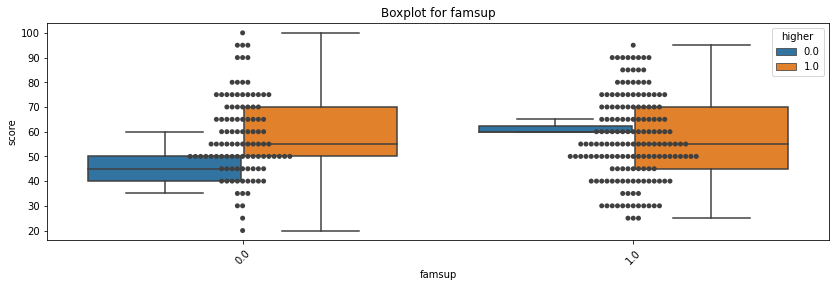

Plotting  paid


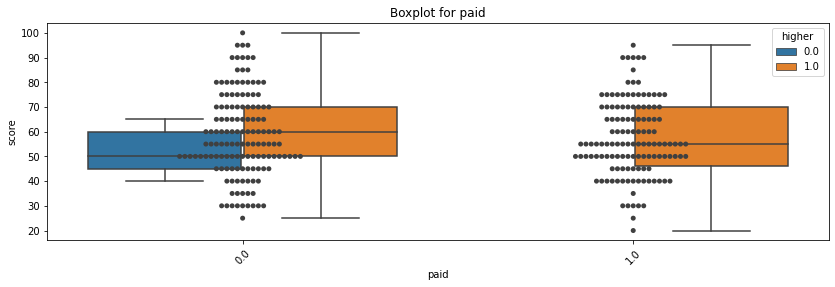

Plotting  activities


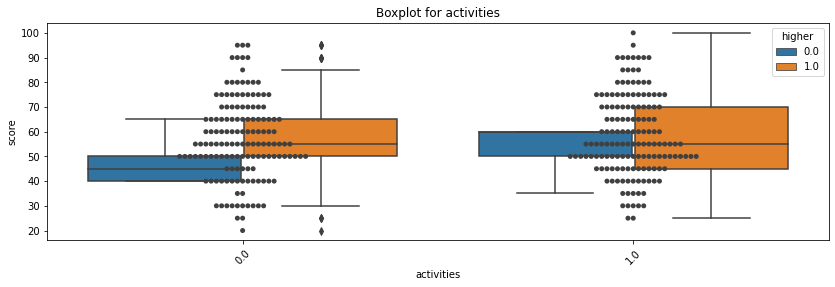

Plotting  nursery


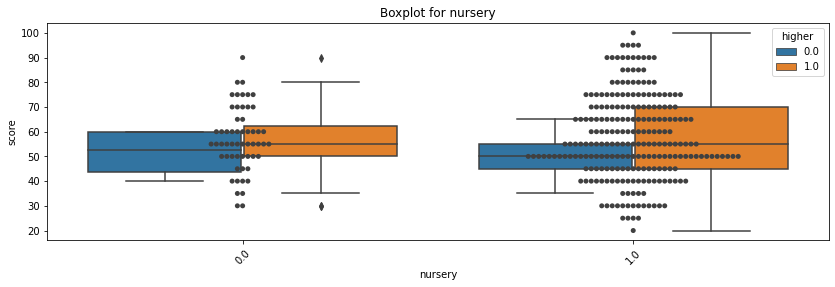

Plotting  internet


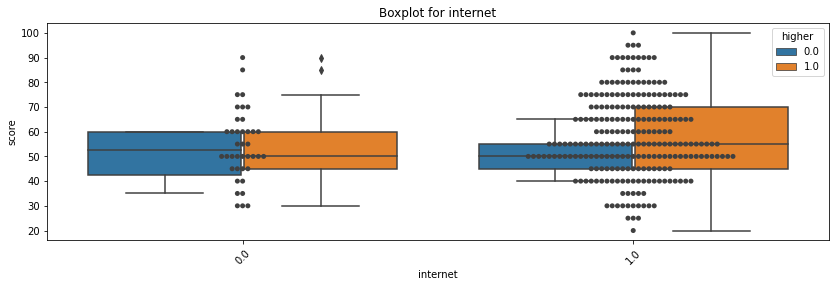

Plotting  romantic


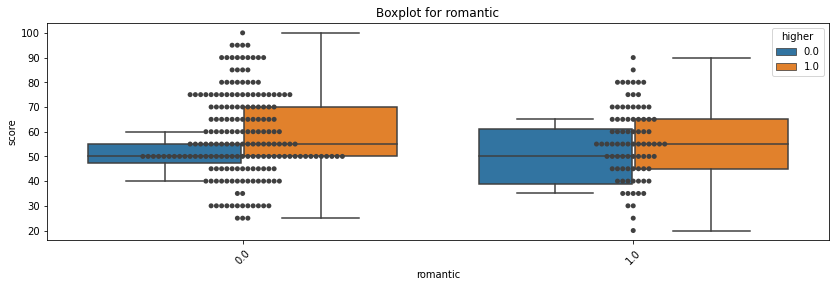

Plotting  famrel


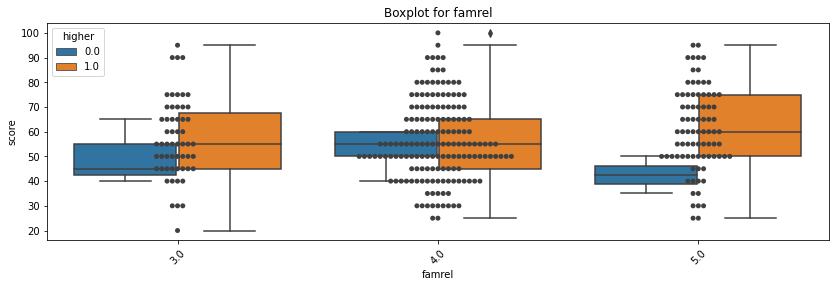

Plotting  freetime


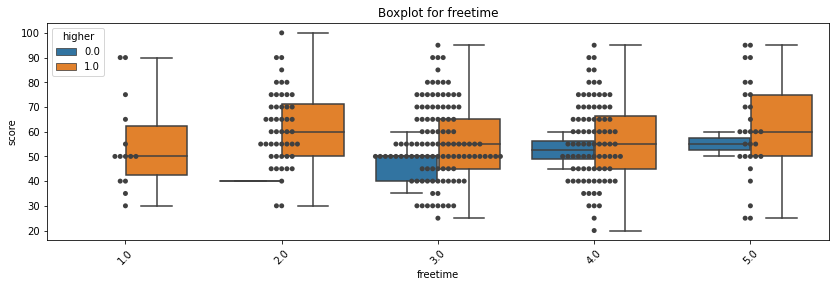

Plotting  goout


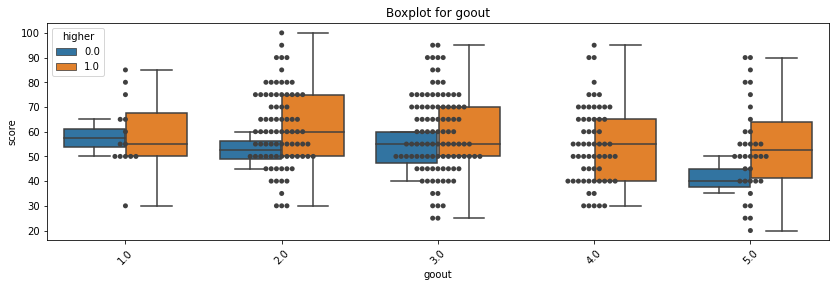

Plotting  health


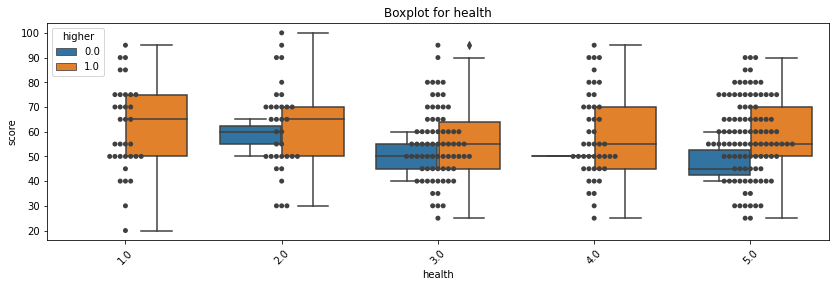

Plotting  absences


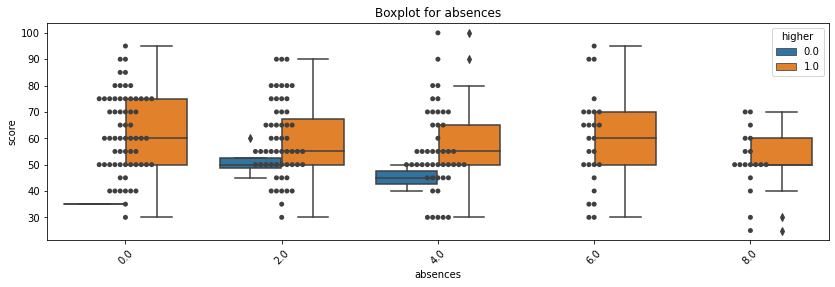

In [342]:
# Здесь мы видим, что желание получить высшее образование очень сильно влияет на улучшение успеваемости у учащихся
for column in df_nonzero_score.columns:
    if column == 'score' or column=='higher':
        continue
    get_boxplot(df=df_nonzero_score, column=column, y='score', hue='higher')

## Анализ графиков
Из графиков мы видим, что 'nursery' и 'famsup' практически никак не влияют на оценку, что подтверждается их низкой корреляцией.

А 'internet' и 'address' ожидаемо влияют на оценку. Так учащиеся в городских школах R(1) в среднем имеют показатели выше, чем учащиеся а сельской местности U(0). Соответственно наличие интернета также в среднем сказывается позитивно на успеваемости. Интересно, что исключение составляет сельская местность - там наличие интернета это негативный фактор.

Очень интересное наблюдение по поводу колонки 'schoolsup'. По описанию это "дополнительная образовательная поддержка", но если она есть, то оказывает резко негативное влияние на успеваемость. Разница в средней успеваемости порой достигает в 20 баллов и больше для некоторых групп учащихся. Также силно разница верхняя граница получаемых оценок. Хотя с другой стороны мы не обладаем информацией, что за учащиеся получают эту поддержку. Вожможно это группы труднообучаемых подростков. В этом случае возможно без данной поддержки успеваемость этих студентов была бы ещё ниже.

Следующая колонка - 'activities'- там не просматривается ярко выраженной зависимости.

В отличии от колонки 'higher'. Здесь мы видим, что желание получить высшее образование очень сильно влияет на улучшение успеваемости у учащихся.
Из анализа данных графиков мы можем сказать что следующие колонны практически никак не влияют на успеваемость учеников из набора данных где оценка на экзамене была больше 0.:

- 'sex' - (0.100243 correlation figure)
- 'famsize' - (-0.023570 correlation figure)
- 'Pstatus' - (-0.017252 correlation figure)
- 'famsup' - (-0.044749 correlation figure)
- 'paid' - (-0.017973 correlation figure)
- 'activities' - (0.056645 correlation figure)
- 'nursery' - (0.023476 correlation figure)
- 'romantic' - (-0.064245 correlation figure)

Ещё колонки с низкой корреляцией (<0.05:
- 'guardian' - (-0.021187 correlation figure)
- 'famrel' - (0.029613 correlation figure)
- 'freetime' - (-0.015933 correlation figure) 
- 'absences' - (-0.013225 correlation figure)

Ещё одно важное наблюдение это то, что несмотря на низкую корреляцию для колонки 'school' - (0.079432 correlation figure) - можно сказать, что в среднем оценки у в школах 'GP'-1 намного выше чем в школах'MS'-0 в подовляющем большинстве случаев.

In [335]:
# Не будем пока убирать колонку 'school' так как небольшая корреляция всё-таки присутствует
candidates_for_removal = ['sex', 'famsize', 'famsup', 'Pstatus', 
                          'paid', 'activities', 'nursery', 'reason',
                          'romantic', 'guardian', 'famrel', 
                          'freetime', 'absences', 'health']

# Убираем данные, которые практически не влияют на оценки
df_nonzero_score_reduced = df_nonzero_score.copy()
for column in candidates_for_removal:
    df_nonzero_score_reduced.drop([column], inplace=True, axis=1)

# Смотрим что получилось
display(df_nonzero_score_reduced.corr())

school       age   address      Medu      Fedu      Mjob  \
school      1.000000 -0.372964  0.289635  0.096936  0.059330 -0.035539   
age        -0.372964  1.000000 -0.174565 -0.122561 -0.091226  0.094079   
address     0.289635 -0.174565  1.000000  0.122638  0.113962 -0.028366   
Medu        0.096936 -0.122561  0.122638  1.000000  0.627468 -0.512516   
Fedu        0.059330 -0.091226  0.113962  0.627468  1.000000 -0.330913   
Mjob       -0.035539  0.094079 -0.028366 -0.512516 -0.330913  1.000000   
Fjob        0.071405  0.036688 -0.051497 -0.246865 -0.387320  0.307395   
traveltime -0.275158  0.136355 -0.238946 -0.164447 -0.194090  0.047396   
studytime   0.076266  0.034690 -0.063143  0.046889 -0.056543  0.027583   
failures    0.023372  0.138225 -0.103531 -0.194420 -0.233770  0.074651   
schoolsup   0.138986 -0.297688  0.019671 -0.026441  0.071322  0.135755   
higher      0.113105 -0.160461  0.028558  0.245944  0.181453 -0.070064   
internet    0.030112 -0.049178  0.164846  0.190734  0.162938 -0.176431   
goout       0.034183  0.091643  0.093323  0.077892  0.034383 -0.086194   
score       0.086302 -0.121946  0.122193  0.160602  0.133722 -0.144897   

                Fjob  traveltime  studytime  failures  schoolsup    higher  \
school      0.071405   -0.275158   0.076266  0.023372   0.138986  0.113105   
age         0.036688    0.136355   0.034690  0.138225  -0.297688 -0.160461   
address    -0.051497   -0.238946  -0.063143 -0.103531   0.019671  0.028558   
Medu       -0.246865   -0.164447   0.046889 -0.194420  -0.026441  0.245944   
Fedu       -0.387320   -0.194090  -0.056543 -0.233770   0.071322  0.181453   
Mjob        0.307395    0.047396   0.027583  0.074651   0.135755 -0.070064   
Fjob        1.000000    0.050236   0.014761  0.004698  -0.089324  0.004591   
traveltime  0.050236    1.000000  -0.173675  0.138721   0.014268 -0.152187   
studytime   0.014761   -0.173675   1.000000 -0.137804   0.025380  0.148489   
failures    0.004698    0.138721  -0.137804  1.000000   0.055584 -0.331548   
schoolsup  -0.089324    0.014268   0.025380  0.055584   1.000000  0.034102   
higher      0.004591   -0.152187   0.148489 -0.331548   0.034102  1.000000   
internet   -0.036097   -0.078424   0.059000 -0.134159  -0.028669  0.132598   
goout      -0.045024    0.012218  -0.054256  0.108299  -0.011028  0.015577   
score      -0.106985   -0.097647   0.155038 -0.244207  -0.259435  0.086651   

            internet     goout     score  
school      0.030112  0.034183  0.086302  
age        -0.049178  0.091643 -0.121946  
address     0.164846  0.093323  0.122193  
Medu        0.190734  0.077892  0.160602  
Fedu        0.162938  0.034383  0.133722  
Mjob       -0.176431 -0.086194 -0.144897  
Fjob       -0.036097 -0.045024 -0.106985  
traveltime -0.078424  0.012218 -0.097647  
studytime   0.059000 -0.054256  0.155038  
failures   -0.134159  0.108299 -0.244207  
schoolsup  -0.028669 -0.011028 -0.259435  
higher      0.132598  0.015577  0.086651  
internet    1.000000  0.151458  0.079676  
goout       0.151458  1.000000 -0.165939  
score       0.079676 -0.165939  1.000000

# Готовим данные для анализа с реальными значениями

Plotting  school


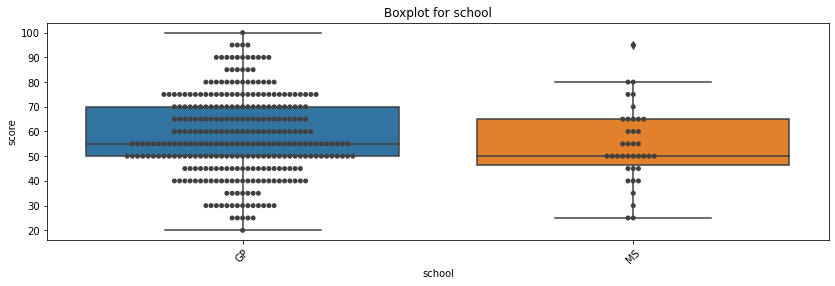

Plotting  age


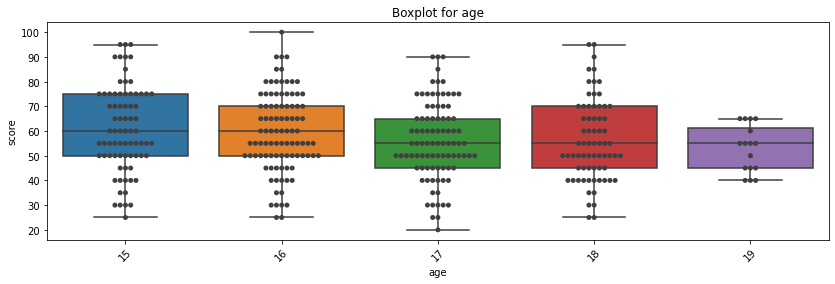

Plotting  address


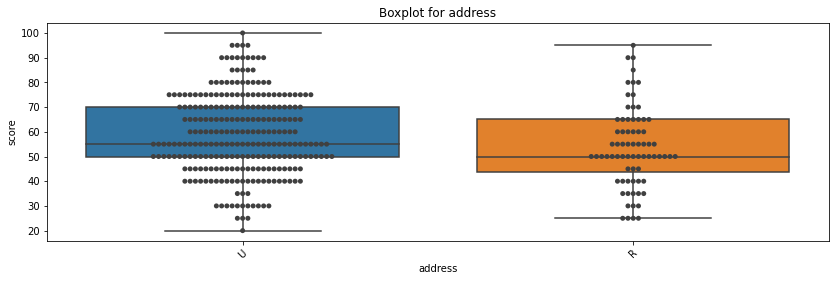

Plotting  traveltime


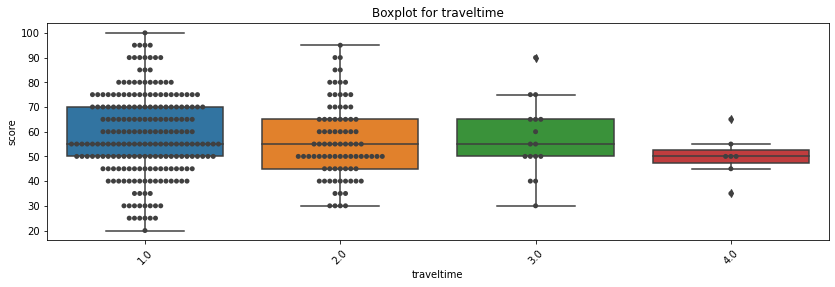

Plotting  studytime


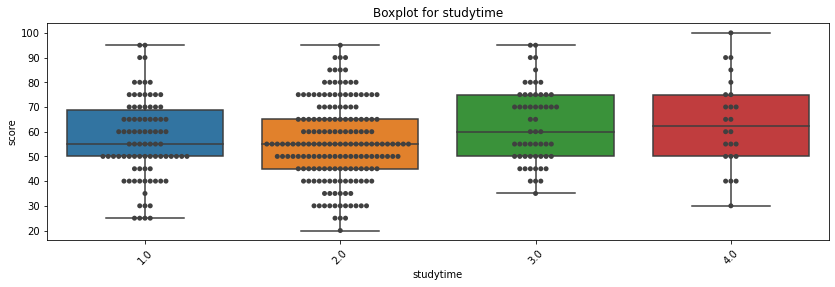

Plotting  failures


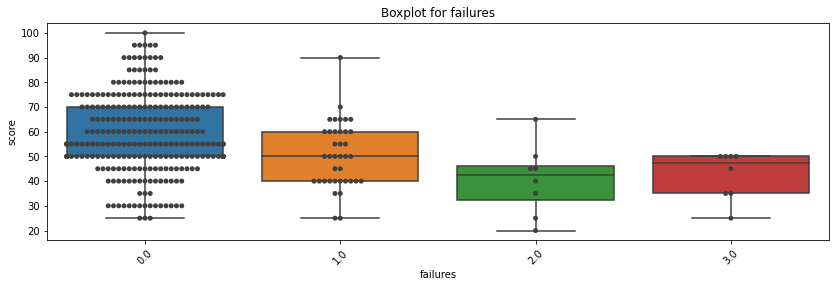

Plotting  schoolsup


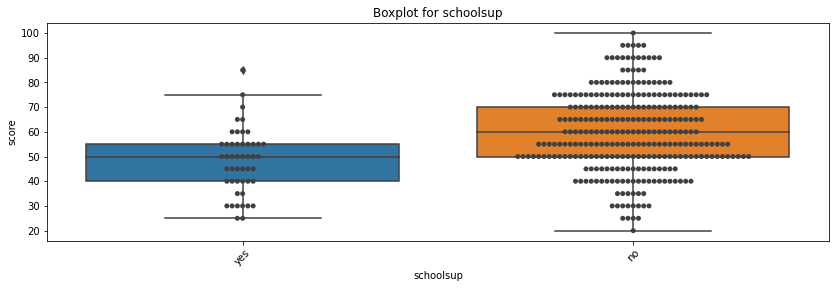

Plotting  higher


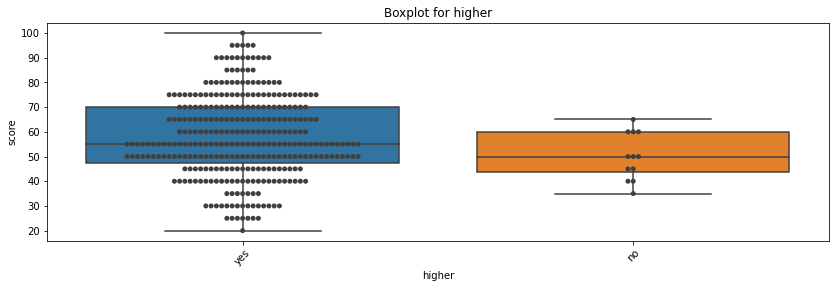

Plotting  internet


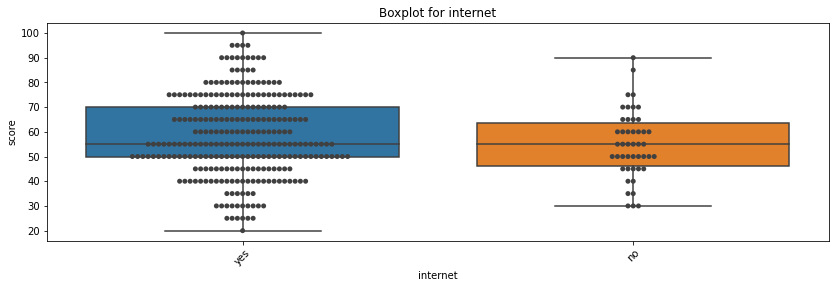

Plotting  goout


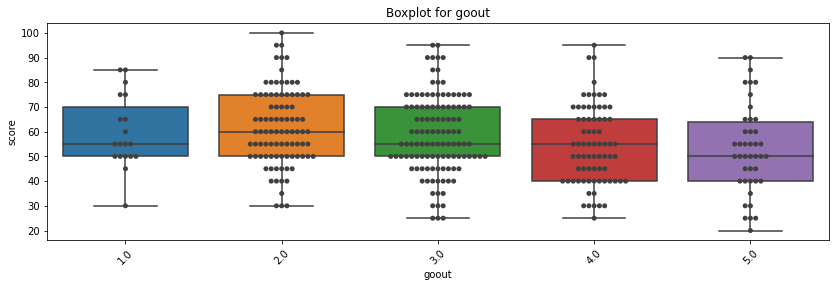

In [343]:
# Преобразуем всё для набора данных с "ненормализованными", строкавыми значениями
# Копируем исходные набор данных
df_reduced = df.copy()

# Убираем значения равные 0 (ученики не учавствовавшие в экзаменах)
df_reduced = df_reduced[df_reduced.score > 0]
df_reduced = df_reduced.drop(df_reduced[df_reduced.age > 19].index)

# Убираем данные, которые практически не влияют на оценки
candidates_for_removal = ['Medu', 'Fedu', 'Mjob', 'Fjob',
                          'sex', 'famsize', 'famsup', 'Pstatus', 
                          'paid', 'activities', 'nursery', 'reason',
                          'romantic', 'guardian', 'famrel', 
                          'freetime', 'absences', 'health']

df_reduced.drop(candidates_for_removal, inplace=True, axis=1)

for column in df_reduced.columns:
    if column == 'score':
        continue
    get_boxplot(df=df_reduced, column=column, y='score', hue=None)

In [344]:
df_reduced.columns

Index(['school', 'age', 'address', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'higher', 'internet', 'goout', 'score'],
      dtype='object')

# Выводы (основные итоги работы)
## Набор "хороших" данных
['school', 'age', 'address', 'traveltime', 'studytime', 'failures', 'schoolsup', 'higher', 'internet', 'goout', 'score']

### Колонки 'school' и 'address'
Два самых глобальных факторов оказыавющих влияние на успеваемость (оценку) учащихся это тип школы 'school' и 'address'. Наиболее высокие баллы получают ученики из:
- школ 'GP'
- проживающие в городе 'U'

### Колонка 'age'
Возраст не оказывает большого влияния на оценку, хотя просматривается явная тенденция к падению среднего балла с увеличением возраста.

### Колонка 'internet'
А 'internet'ожидаемо влиет на оценку - наличие интернета в среднем сказывается позитивно на успеваемости. Интересно, что исключение составляет сельская местность - там наличие интернета это негативный фактор.

### Колонки 'Medu', 'Fedu', 'Mjob' и 'Fjob'
Несмотря на их относительно высокую корреляцию (соответственно 0.185018, 0.133649, -0.162727, -0.108363) относительно оценок (по сравнению с другими корреляциями) при анализе графиков мы видим, что в основном данные в этих колонках слабо влияют на оценки. Разброс среднего балла не больше 5-7 баллов. Небольшое исключение (позитивное влияние) составляет работа отца учителем (Fjob 0) но таких учеников не много.

Также можно видеть что для 'Medu' и 'Fedu' отсутствие образования у отца или матери (0) это позитивный фактор, но по факту мы видим что это больше влияние малой выборки: в 'Medu' только у троих учеников у матери нет образования, в 'Fedu' только у двоих учеников у отца нет образования.

### Колонка 'studytime'
Ожидаемо чем больше времени в среднем затрачивает ученик на внешкольную учёбу, тем выше средний бал, хотя огромного увеличения не просматривается.

### Колонка 'failures'
Один из самых больших факторов оказывающих негативное влияние на успеваемость ученика это количество внеучебных неудач. Чем оно выше - тем ниже средние баллы.

### Колонка 'schoolsup'
Очень интересное наблюдение по поводу колонки 'schoolsup'. По описанию это "дополнительная образовательная поддержка", но если она есть, то оказывает резко негативное влияние на успеваемость. Разница в средней успеваемости порой достигает в 20 баллов и больше для некоторых групп учащихся. Также силно разница верхняя граница получаемых оценок. Хотя с другой стороны мы не обладаем информацией, что за учащиеся получают эту поддержку. Вожможно это группы труднообучаемых подростков. В этом случае возможно без данной поддержки успеваемость этих студентов была бы ещё ниже.

### Колонка 'higher'
В отличии от колонки 'higher'. Здесь мы видим, что желание получить высшее образование очень сильно влияет на улучшение успеваемости у учащихся. Из анализа данных графиков мы можем сказать что следующие колонны практически никак не влияют на успеваемость учеников из набора данных где оценка на экзамене была больше 0.

### Колонка 'traveltime'
Преимущество явно имеют учащиеся которые живут не дальше 30 минут от школы, потом начинаются проблеммы. Учащиеся живущие далше чем 30 минут от школы, практически не имеют шанса на отличную оценку.

### Колонка 'goout'
Если ученик проводит с друзьями достаточно, но не очень много времени (2-3 по 5-бальной шкале от 1 - очень мало до 5 - очень много) то у него больше шансов получить хорошую оценку. Увеличение или уменьшение этого значения негативно сказывается на успеваемости.

